In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/CIRUGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=145.0, y1=114.7
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 515
Page 1, Q1, A: Yellow percentage: 0.0%


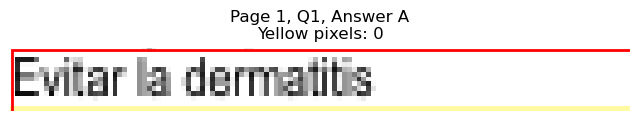

Page 1, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=148.0, y1=127.3
Page 1, Q1, B: Yellow pixels: 1274
Page 1, Q1, B: Total non-white pixels: 1820
Page 1, Q1, B: Yellow percentage: 70.0%


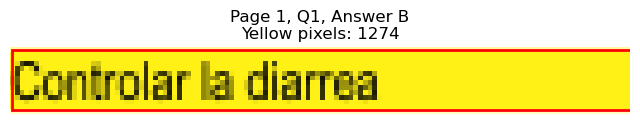

Page 1, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=447.9, y1=114.7
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 601
Page 1, Q1, C: Yellow percentage: 0.0%


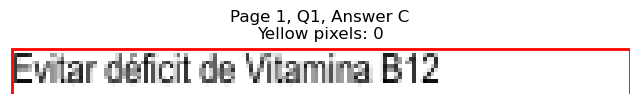

Page 1, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=440.8, y1=127.3
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 585
Page 1, Q1, D: Yellow percentage: 0.0%


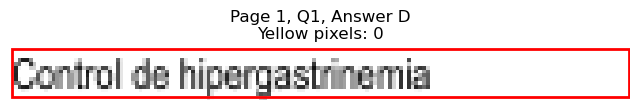


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=178.1, y1=165.2
Page 1, Q2, A: Yellow pixels: 161
Page 1, Q2, A: Total non-white pixels: 706
Page 1, Q2, A: Yellow percentage: 22.8%


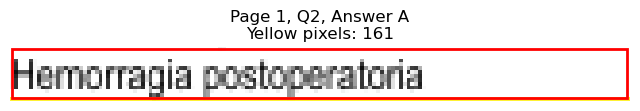

Page 1, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=144.0, y1=177.8
Page 1, Q2, B: Yellow pixels: 1366
Page 1, Q2, B: Total non-white pixels: 1651
Page 1, Q2, B: Yellow percentage: 82.7%


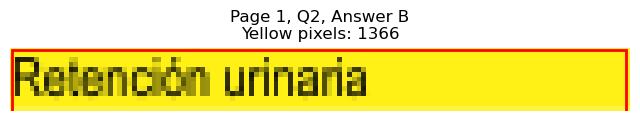

Page 1, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=388.7, y1=165.2
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 310
Page 1, Q2, C: Yellow percentage: 0.0%


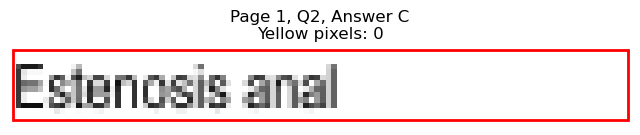

Page 1, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=404.8, y1=177.8
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 398
Page 1, Q2, D: Yellow percentage: 0.0%


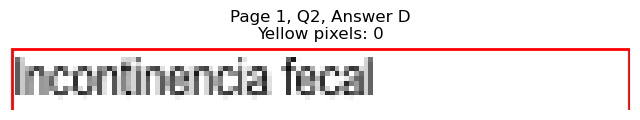


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=132.5, y1=228.3
Page 1, Q3, A: Yellow pixels: 1146
Page 1, Q3, A: Total non-white pixels: 1610
Page 1, Q3, A: Yellow percentage: 71.2%


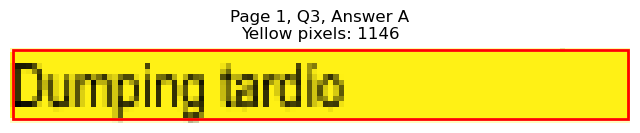

Page 1, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=148.1, y1=240.9
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 511
Page 1, Q3, B: Yellow percentage: 0.0%


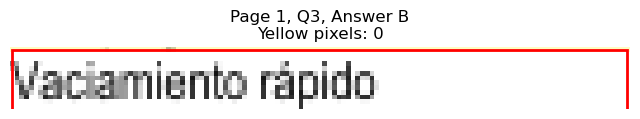

Page 1, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=424.9, y1=228.3
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 488
Page 1, Q3, C: Yellow percentage: 0.0%


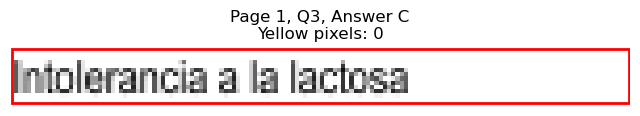

Page 1, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=491.0, y1=240.9
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 851
Page 1, Q3, D: Yellow percentage: 0.0%


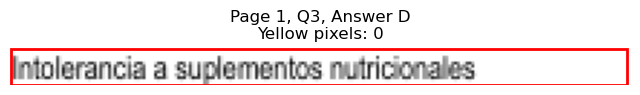


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=141.0, y1=278.7
Page 1, Q4, A: Yellow pixels: 1325
Page 1, Q4, A: Total non-white pixels: 1612
Page 1, Q4, A: Yellow percentage: 82.2%


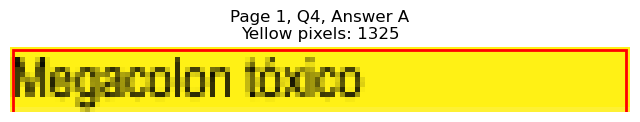

Page 1, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=158.1, y1=291.5
Page 1, Q4, B: Yellow pixels: 140
Page 1, Q4, B: Total non-white pixels: 580
Page 1, Q4, B: Yellow percentage: 24.1%


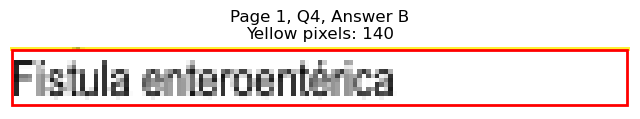

Page 1, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=389.7, y1=278.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 328
Page 1, Q4, C: Yellow percentage: 0.0%


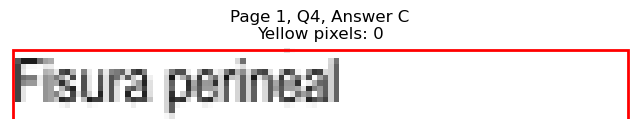

Page 1, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=404.2, y1=291.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 424
Page 1, Q4, D: Yellow percentage: 0.0%


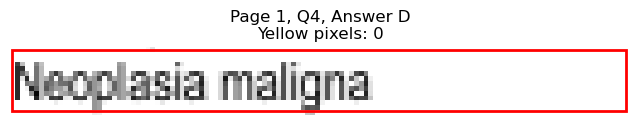


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=170.7, y1=341.9
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 531
Page 1, Q5, A: Yellow percentage: 0.0%


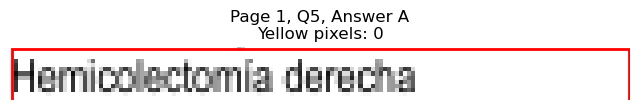

Page 1, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=269.4, y1=354.6
Page 1, Q5, B: Yellow pixels: 62
Page 1, Q5, B: Total non-white pixels: 1112
Page 1, Q5, B: Yellow percentage: 5.6%


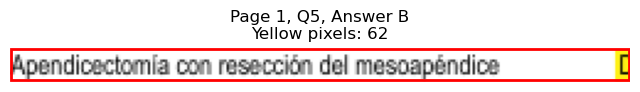

Page 1, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=423.3, y1=341.9
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 496
Page 1, Q5, C: Yellow percentage: 0.0%


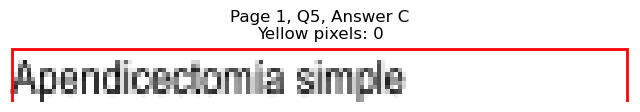

Page 1, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=541.2, y1=354.6
Page 1, Q5, D: Yellow pixels: 1926
Page 1, Q5, D: Total non-white pixels: 2995
Page 1, Q5, D: Yellow percentage: 64.3%


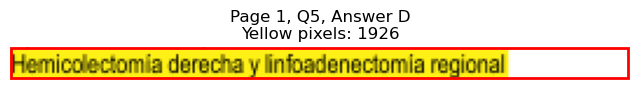


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=122.0, y1=405.0
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 258
Page 1, Q6, A: Yellow percentage: 0.0%


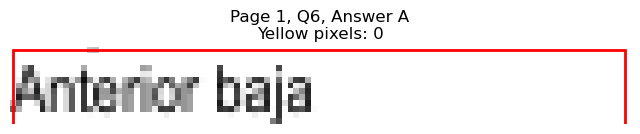

Page 1, Q6 - B: Detected box: x0=68.3, y0=404.9, x1=223.8, y1=417.6
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 759
Page 1, Q6, B: Yellow percentage: 0.0%


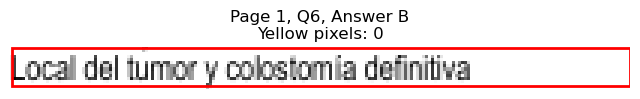

Page 1, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=432.4, y1=405.0
Page 1, Q6, C: Yellow pixels: 1629
Page 1, Q6, C: Total non-white pixels: 2028
Page 1, Q6, C: Yellow percentage: 80.3%


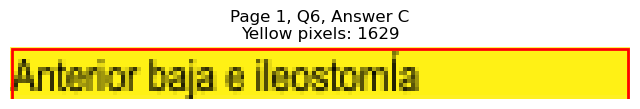

Page 1, Q6 - D: Detected box: x0=327.5, y0=404.9, x1=405.3, y1=417.6
Page 1, Q6, D: Yellow pixels: 127
Page 1, Q6, D: Total non-white pixels: 524
Page 1, Q6, D: Yellow percentage: 24.2%


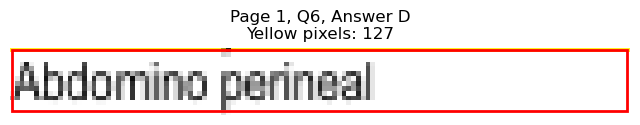


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=262.4, y1=455.5
Page 1, Q7, A: Yellow pixels: 2030
Page 1, Q7, A: Total non-white pixels: 2996
Page 1, Q7, A: Yellow percentage: 67.8%


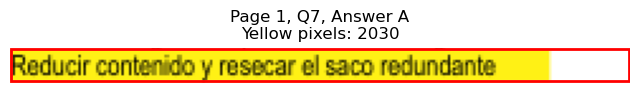

Page 1, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=223.2, y1=468.1
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 736
Page 1, Q7, B: Yellow percentage: 0.0%


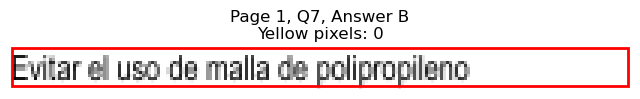

Page 1, Q7 - C: Detected box: x0=327.5, y0=442.8, x1=467.5, y1=455.5
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 696
Page 1, Q7, C: Yellow percentage: 0.0%


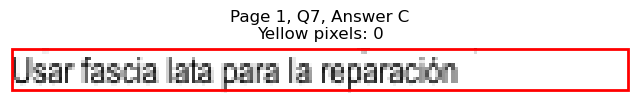

Page 1, Q7 - D: Detected box: x0=327.5, y0=455.5, x1=435.4, y1=468.1
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 562
Page 1, Q7, D: Yellow percentage: 0.0%


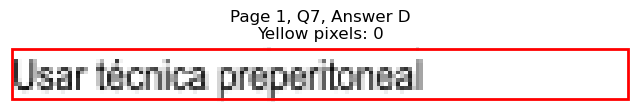


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=506.0, x1=138.1, y1=518.6
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 370
Page 1, Q8, A: Yellow percentage: 0.0%


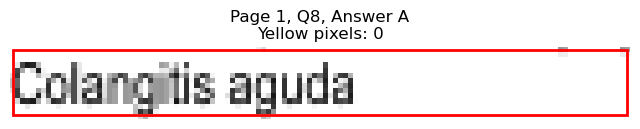

Page 1, Q8 - B: Detected box: x0=68.3, y0=518.6, x1=145.6, y1=531.2
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 426
Page 1, Q8, B: Yellow percentage: 0.0%


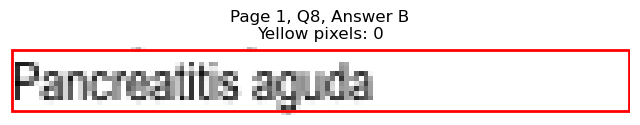

Page 1, Q8 - C: Detected box: x0=327.5, y0=506.0, x1=400.7, y1=518.6
Page 1, Q8, C: Yellow pixels: 124
Page 1, Q8, C: Total non-white pixels: 533
Page 1, Q8, C: Yellow percentage: 23.3%


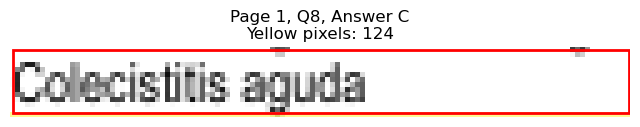

Page 1, Q8 - D: Detected box: x0=327.5, y0=518.6, x1=366.2, y1=531.2
Page 1, Q8, D: Yellow pixels: 1017
Page 1, Q8, D: Total non-white pixels: 1260
Page 1, Q8, D: Yellow percentage: 80.7%


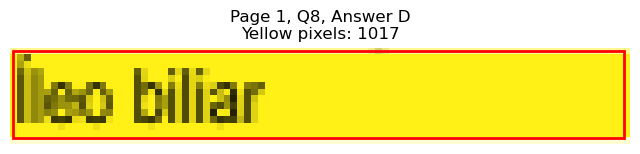


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=569.1, x1=214.4, y1=581.8
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 766
Page 1, Q9, A: Yellow percentage: 0.0%


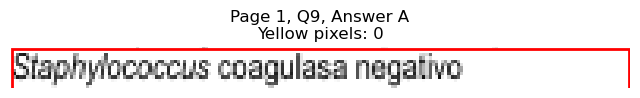

Page 1, Q9 - B: Detected box: x0=68.3, y0=581.7, x1=125.5, y1=594.4
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 283
Page 1, Q9, B: Yellow percentage: 0.0%


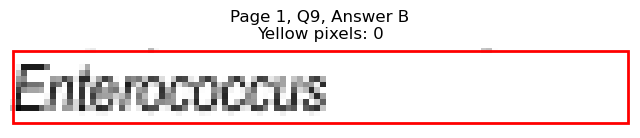

Page 1, Q9 - C: Detected box: x0=327.5, y0=569.1, x1=392.7, y1=581.8
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 453
Page 1, Q9, C: Yellow percentage: 0.0%


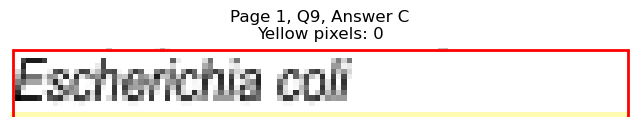

Page 1, Q9 - D: Detected box: x0=327.5, y0=581.7, x1=423.3, y1=594.4
Page 1, Q9, D: Yellow pixels: 1395
Page 1, Q9, D: Total non-white pixels: 2058
Page 1, Q9, D: Yellow percentage: 67.8%


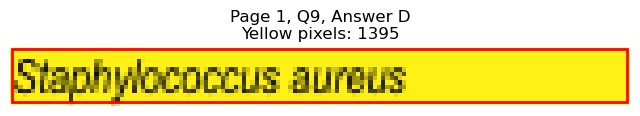


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=644.9, x1=93.9, y1=657.5
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 127
Page 1, Q10, A: Yellow percentage: 0.0%


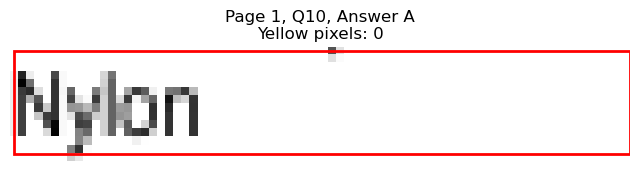

Page 1, Q10 - B: Detected box: x0=68.3, y0=657.5, x1=126.0, y1=670.1
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 280
Page 1, Q10, B: Yellow percentage: 0.0%


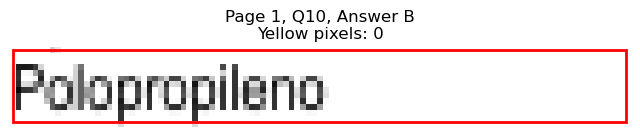

Page 1, Q10 - C: Detected box: x0=327.5, y0=644.9, x1=382.7, y1=657.5
Page 1, Q10, C: Yellow pixels: 1174
Page 1, Q10, C: Total non-white pixels: 1484
Page 1, Q10, C: Yellow percentage: 79.1%


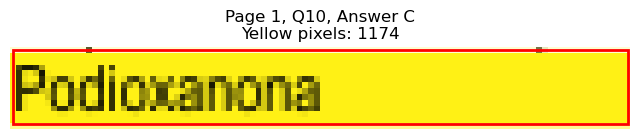

Page 1, Q10 - D: Detected box: x0=327.5, y0=657.5, x1=393.8, y1=670.1
Page 1, Q10, D: Yellow pixels: 117
Page 1, Q10, D: Total non-white pixels: 457
Page 1, Q10, D: Yellow percentage: 25.6%


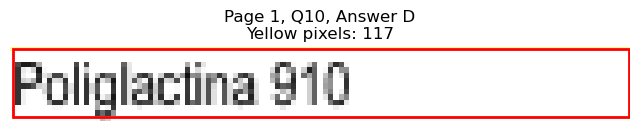


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=708.0, x1=112.0, y1=720.6
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 199
Page 1, Q11, A: Yellow percentage: 0.0%


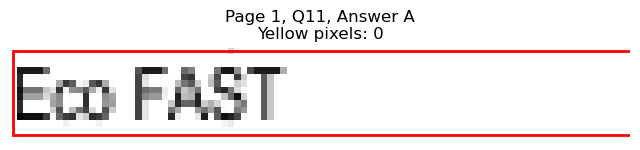

Page 1, Q11 - B: Detected box: x0=68.3, y0=720.6, x1=153.6, y1=733.2
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 445
Page 1, Q11, B: Yellow percentage: 0.0%


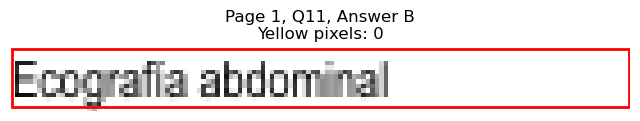

Page 1, Q11 - C: Detected box: x0=327.5, y0=708.0, x1=458.0, y1=720.6
Page 1, Q11, C: Yellow pixels: 181
Page 1, Q11, C: Total non-white pixels: 875
Page 1, Q11, C: Yellow percentage: 20.7%


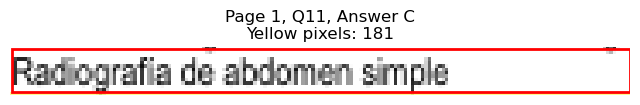

Page 1, Q11 - D: Detected box: x0=327.5, y0=720.6, x1=440.4, y1=733.2
Page 1, Q11, D: Yellow pixels: 1718
Page 1, Q11, D: Total non-white pixels: 2296
Page 1, Q11, D: Yellow percentage: 74.8%


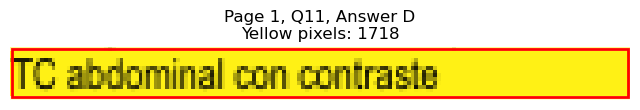


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=374.2, y1=102.1
Page 2, Q1, A: Yellow pixels: 357
Page 2, Q1, A: Total non-white pixels: 1918
Page 2, Q1, A: Yellow percentage: 18.6%


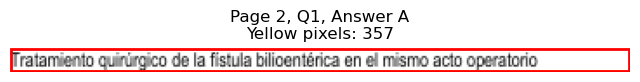

Page 2, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=225.9, y1=114.7
Page 2, Q1, B: Yellow pixels: 2110
Page 2, Q1, B: Total non-white pixels: 2704
Page 2, Q1, B: Yellow percentage: 78.0%


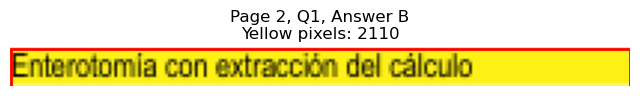

Page 2, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=169.6, y1=127.3
Page 2, Q1, C: Yellow pixels: 152
Page 2, Q1, C: Total non-white pixels: 698
Page 2, Q1, C: Yellow percentage: 21.8%


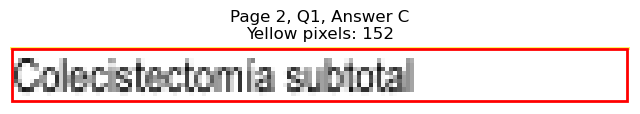

Page 2, Q1 - D: Detected box: x0=68.8, y0=127.2, x1=135.5, y1=139.9
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 357
Page 2, Q1, D: Yellow percentage: 0.0%


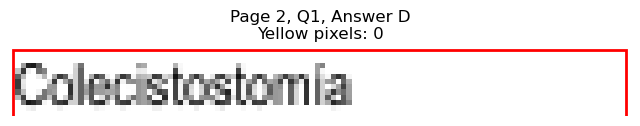


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=102.9, y1=177.8
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 166
Page 2, Q2, A: Yellow percentage: 0.0%


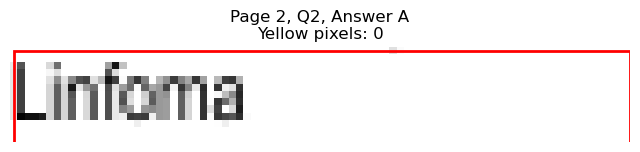

Page 2, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=135.0, y1=190.4
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 330
Page 2, Q2, B: Yellow percentage: 0.0%


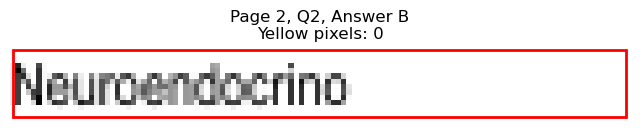

Page 2, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=397.7, y1=177.8
Page 2, Q2, C: Yellow pixels: 1319
Page 2, Q2, C: Total non-white pixels: 1573
Page 2, Q2, C: Yellow percentage: 83.9%


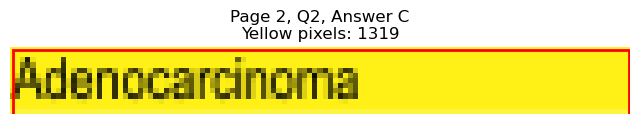

Page 2, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=396.3, y1=190.4
Page 2, Q2, D: Yellow pixels: 120
Page 2, Q2, D: Total non-white pixels: 447
Page 2, Q2, D: Yellow percentage: 26.8%


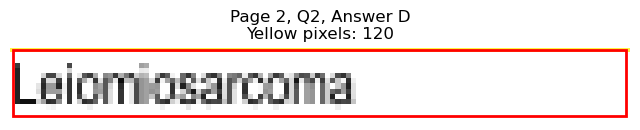


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=165.1, y1=253.5
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 529
Page 2, Q3, A: Yellow percentage: 0.0%


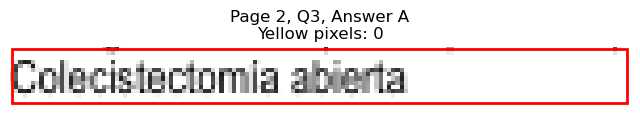

Page 2, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=257.4, y1=266.1
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 978
Page 2, Q3, B: Yellow percentage: 0.0%


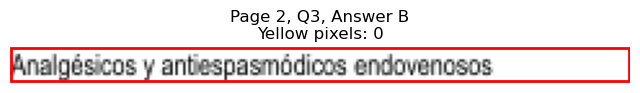

Page 2, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=452.5, y1=253.5
Page 2, Q3, C: Yellow pixels: 1773
Page 2, Q3, C: Total non-white pixels: 2464
Page 2, Q3, C: Yellow percentage: 72.0%


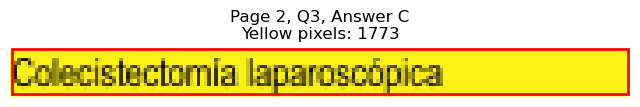

Page 2, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=455.0, y1=266.1
Page 2, Q3, D: Yellow pixels: 178
Page 2, Q3, D: Total non-white pixels: 828
Page 2, Q3, D: Yellow percentage: 21.5%


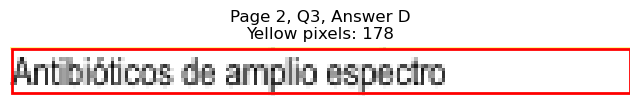


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=161.1, y1=316.7
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 467
Page 2, Q4, A: Yellow percentage: 0.0%


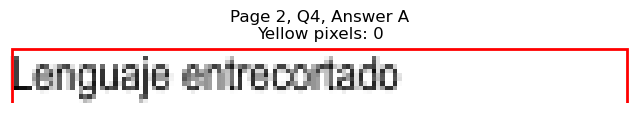

Page 2, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=130.9, y1=329.3
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 311
Page 2, Q4, B: Yellow percentage: 0.0%


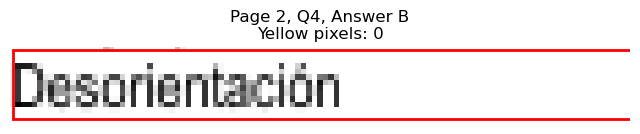

Page 2, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=374.2, y1=316.7
Page 2, Q4, C: Yellow pixels: 1090
Page 2, Q4, C: Total non-white pixels: 1274
Page 2, Q4, C: Yellow percentage: 85.6%


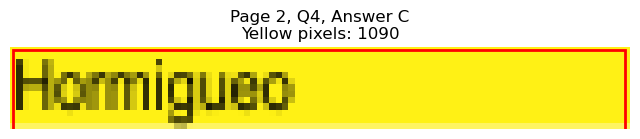

Page 2, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=374.7, y1=329.3
Page 2, Q4, D: Yellow pixels: 96
Page 2, Q4, D: Total non-white pixels: 337
Page 2, Q4, D: Yellow percentage: 28.5%


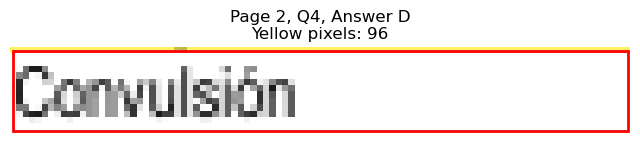


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=179.7, y1=367.2
Page 2, Q5, A: Yellow pixels: 162
Page 2, Q5, A: Total non-white pixels: 745
Page 2, Q5, A: Yellow percentage: 21.7%


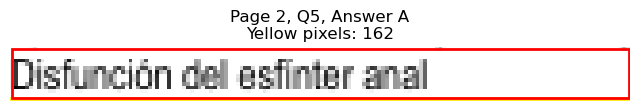

Page 2, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=140.1, y1=379.8
Page 2, Q5, B: Yellow pixels: 1315
Page 2, Q5, B: Total non-white pixels: 1599
Page 2, Q5, B: Yellow percentage: 82.2%


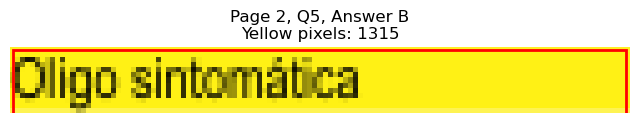

Page 2, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=366.2, y1=367.2
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 200
Page 2, Q5, C: Yellow percentage: 0.0%


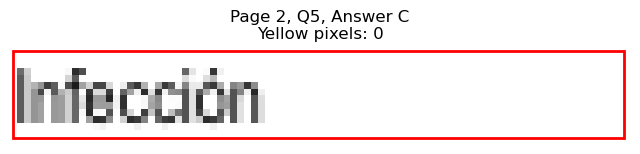

Page 2, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=398.2, y1=379.8
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 357
Page 2, Q5, D: Yellow percentage: 0.0%


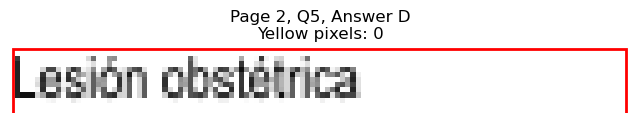


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=154.6, y1=442.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 558
Page 2, Q6, A: Yellow percentage: 0.0%


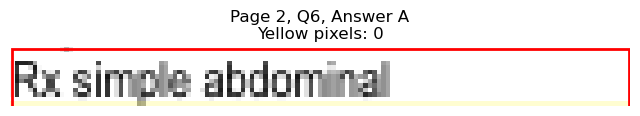

Page 2, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=153.6, y1=455.5
Page 2, Q6, B: Yellow pixels: 1405
Page 2, Q6, B: Total non-white pixels: 1904
Page 2, Q6, B: Yellow percentage: 73.8%


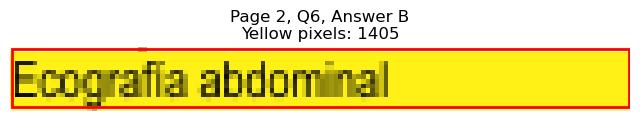

Page 2, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=434.8, y1=442.9
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 533
Page 2, Q6, C: Yellow percentage: 0.0%


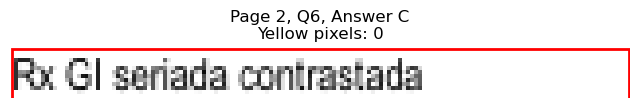

Page 2, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=420.3, y1=455.5
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 476
Page 2, Q6, D: Yellow percentage: 0.0%


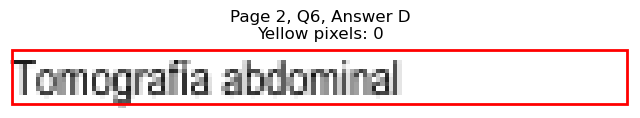


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=275.0, y1=493.4
Page 2, Q7, A: Yellow pixels: 2264
Page 2, Q7, A: Total non-white pixels: 3598
Page 2, Q7, A: Yellow percentage: 62.9%


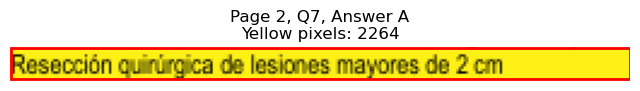

Page 2, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=296.1, y1=506.0
Page 2, Q7, B: Yellow pixels: 4
Page 2, Q7, B: Total non-white pixels: 1435
Page 2, Q7, B: Yellow percentage: 0.3%


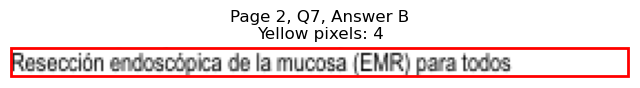

Page 2, Q7 - C: Detected box: x0=68.8, y0=506.0, x1=279.9, y1=518.6
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 1043
Page 2, Q7, C: Yellow percentage: 0.0%


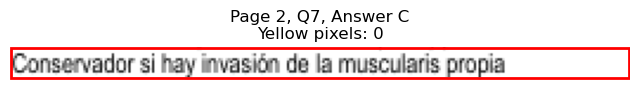

Page 2, Q7 - D: Detected box: x0=68.8, y0=518.6, x1=287.4, y1=531.2
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 1056
Page 2, Q7, D: Yellow percentage: 0.0%


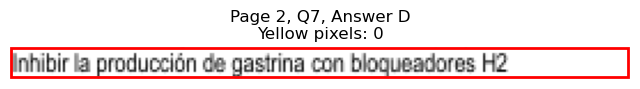


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=135.0, y1=569.2
Page 2, Q8, A: Yellow pixels: 118
Page 2, Q8, A: Total non-white pixels: 494
Page 2, Q8, A: Yellow percentage: 23.9%


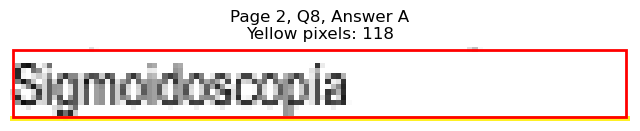

Page 2, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=126.0, y1=581.8
Page 2, Q8, B: Yellow pixels: 1198
Page 2, Q8, B: Total non-white pixels: 1417
Page 2, Q8, B: Yellow percentage: 84.5%


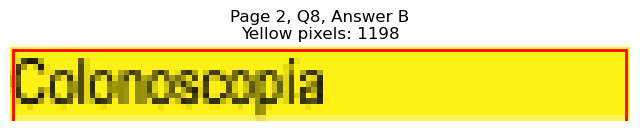

Page 2, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=379.7, y1=569.2
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 285
Page 2, Q8, C: Yellow percentage: 0.0%


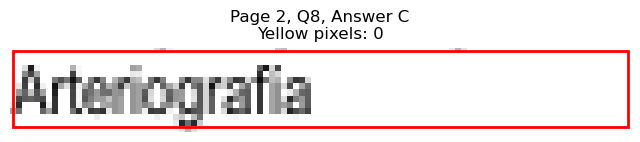

Page 2, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=403.3, y1=581.8
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 394
Page 2, Q8, D: Yellow percentage: 0.0%


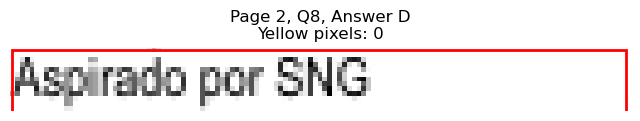


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=186.1, y1=644.9
Page 2, Q9, A: Yellow pixels: 1731
Page 2, Q9, A: Total non-white pixels: 2197
Page 2, Q9, A: Yellow percentage: 78.8%


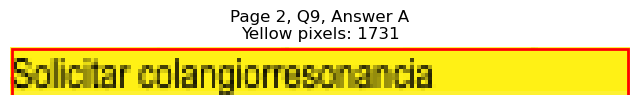

Page 2, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=198.3, y1=657.5
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 644
Page 2, Q9, B: Yellow percentage: 0.0%


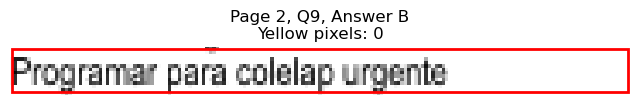

Page 2, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=419.3, y1=644.9
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 476
Page 2, Q9, C: Yellow percentage: 0.0%


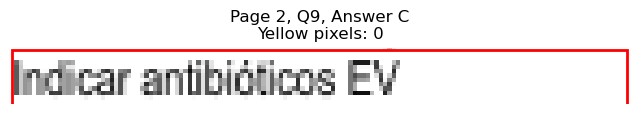

Page 2, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=466.5, y1=657.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 718
Page 2, Q9, D: Yellow percentage: 0.0%


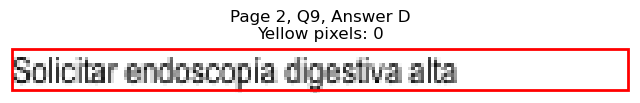


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=682.8, x1=113.9, y1=695.4
Page 2, Q10, A: Yellow pixels: 96
Page 2, Q10, A: Total non-white pixels: 338
Page 2, Q10, A: Yellow percentage: 28.4%


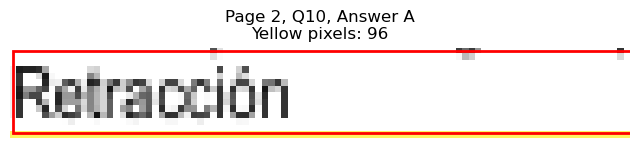

Page 2, Q10 - B: Detected box: x0=68.3, y0=695.4, x1=105.9, y1=708.0
Page 2, Q10, B: Yellow pixels: 1003
Page 2, Q10, B: Total non-white pixels: 1144
Page 2, Q10, B: Yellow percentage: 87.7%


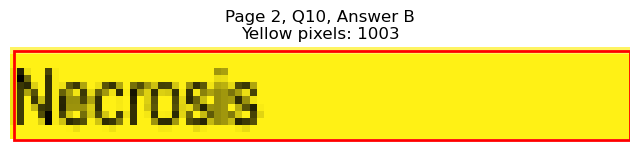

Page 2, Q10 - C: Detected box: x0=327.5, y0=682.8, x1=365.7, y1=695.4
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 183
Page 2, Q10, C: Yellow percentage: 0.0%


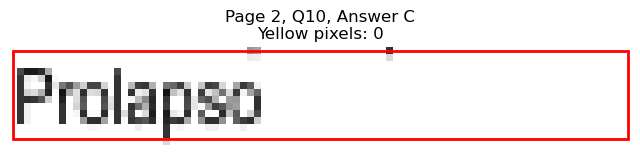

Page 2, Q10 - D: Detected box: x0=327.5, y0=695.4, x1=408.8, y1=708.0
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 414
Page 2, Q10, D: Yellow percentage: 0.0%


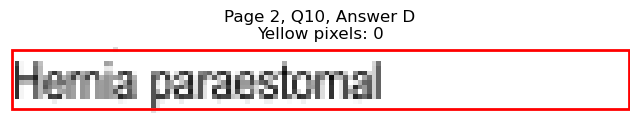


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=153.6, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 445
Page 3, Q1, A: Yellow percentage: 0.0%


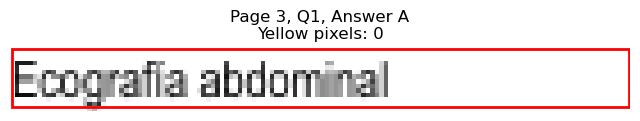

Page 3, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=163.1, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 447
Page 3, Q1, B: Yellow percentage: 0.0%


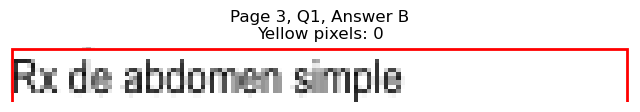

Page 3, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=439.9, y1=127.3
Page 3, Q1, C: Yellow pixels: 163
Page 3, Q1, C: Total non-white pixels: 732
Page 3, Q1, C: Yellow percentage: 22.3%


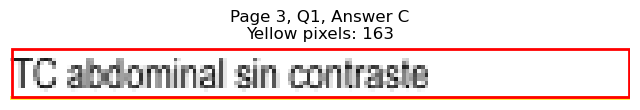

Page 3, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=422.3, y1=139.9
Page 3, Q1, D: Yellow pixels: 1514
Page 3, Q1, D: Total non-white pixels: 1898
Page 3, Q1, D: Yellow percentage: 79.8%


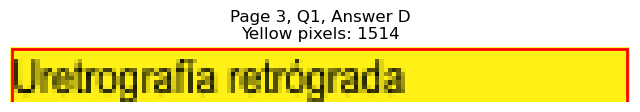


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=124.5, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 297
Page 3, Q2, A: Yellow percentage: 0.0%


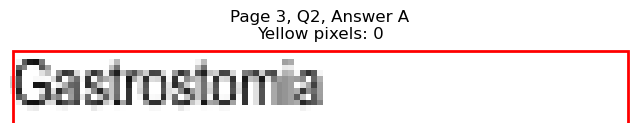

Page 3, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=159.1, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 467
Page 3, Q2, B: Yellow percentage: 0.0%


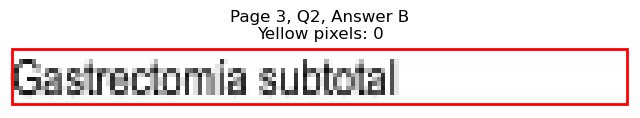

Page 3, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=432.8, y1=177.8
Page 3, Q2, C: Yellow pixels: 1613
Page 3, Q2, C: Total non-white pixels: 2028
Page 3, Q2, C: Yellow percentage: 79.5%


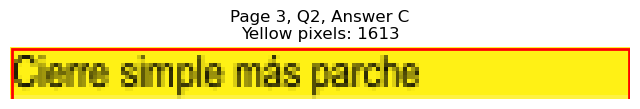

Page 3, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=406.7, y1=190.4
Page 3, Q2, D: Yellow pixels: 130
Page 3, Q2, D: Total non-white pixels: 542
Page 3, Q2, D: Yellow percentage: 24.0%


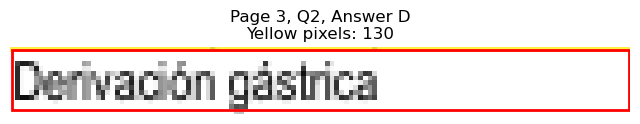


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=313.6, y1=253.5
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 1236
Page 3, Q3, A: Yellow percentage: 0.0%


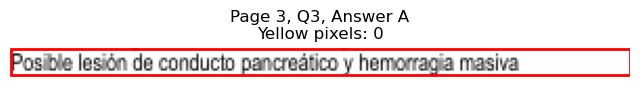

Page 3, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=251.8, y1=266.1
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 915
Page 3, Q3, B: Yellow percentage: 0.0%


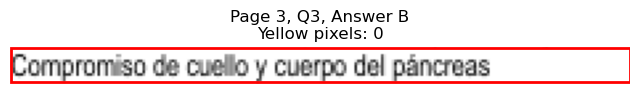

Page 3, Q3 - C: Detected box: x0=68.8, y0=266.1, x1=316.1, y1=278.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 1203
Page 3, Q3, C: Yellow percentage: 0.0%


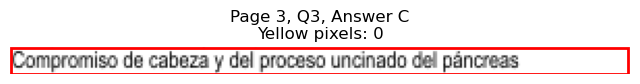

Page 3, Q3 - D: Detected box: x0=68.8, y0=278.8, x1=267.5, y1=291.5
Page 3, Q3, D: Yellow pixels: 2476
Page 3, Q3, D: Total non-white pixels: 3500
Page 3, Q3, D: Yellow percentage: 70.7%


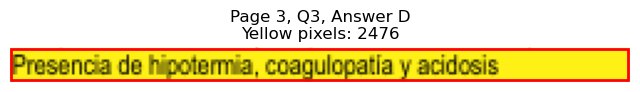


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=286.5, y1=354.6
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 1068
Page 3, Q4, A: Yellow percentage: 0.0%


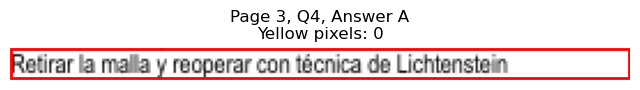

Page 3, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=205.2, y1=367.2
Page 3, Q4, B: Yellow pixels: 188
Page 3, Q4, B: Total non-white pixels: 848
Page 3, Q4, B: Yellow percentage: 22.2%


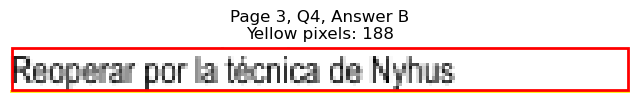

Page 3, Q4 - C: Detected box: x0=68.8, y0=367.1, x1=291.4, y1=379.8
Page 3, Q4, C: Yellow pixels: 2708
Page 3, Q4, C: Total non-white pixels: 3562
Page 3, Q4, C: Yellow percentage: 76.0%


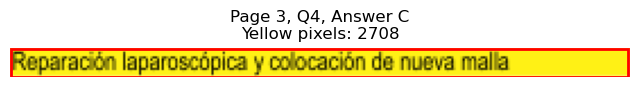

Page 3, Q4 - D: Detected box: x0=68.8, y0=379.7, x1=232.7, y1=392.4
Page 3, Q4, D: Yellow pixels: 214
Page 3, Q4, D: Total non-white pixels: 1009
Page 3, Q4, D: Yellow percentage: 21.2%


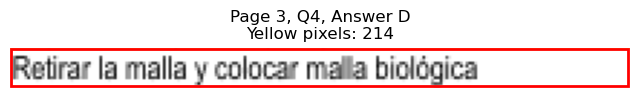


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=128.5, y1=430.3
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 321
Page 3, Q5, A: Yellow percentage: 0.0%


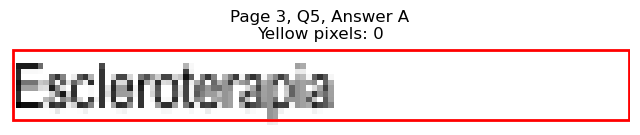

Page 3, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=159.0, y1=442.9
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 453
Page 3, Q5, B: Yellow percentage: 0.0%


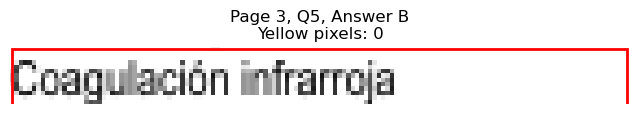

Page 3, Q5 - C: Detected box: x0=327.5, y0=417.6, x1=373.6, y1=430.3
Page 3, Q5, C: Yellow pixels: 97
Page 3, Q5, C: Total non-white pixels: 341
Page 3, Q5, C: Yellow percentage: 28.4%


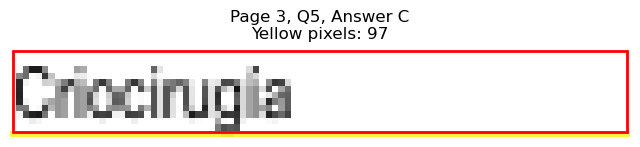

Page 3, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=440.3, y1=442.9
Page 3, Q5, D: Yellow pixels: 1707
Page 3, Q5, D: Total non-white pixels: 2132
Page 3, Q5, D: Yellow percentage: 80.1%


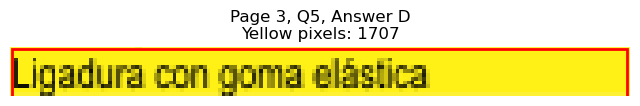


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=114.6, x1=153.6, y1=127.3
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 445
Page 3, Q6, A: Yellow percentage: 0.0%


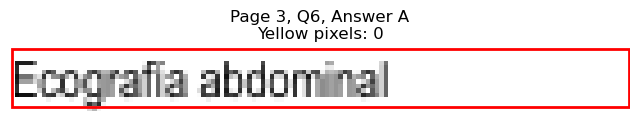

Page 3, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=170.1, y1=506.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 512
Page 3, Q6, B: Yellow percentage: 0.0%


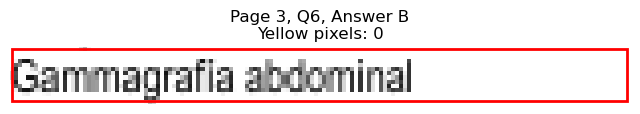

Page 3, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=388.3, y1=493.4
Page 3, Q6, C: Yellow pixels: 112
Page 3, Q6, C: Total non-white pixels: 437
Page 3, Q6, C: Yellow percentage: 25.6%


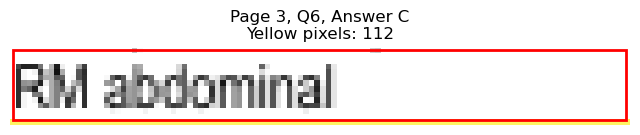

Page 3, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=382.3, y1=506.0
Page 3, Q6, D: Yellow pixels: 1171
Page 3, Q6, D: Total non-white pixels: 1378
Page 3, Q6, D: Yellow percentage: 85.0%


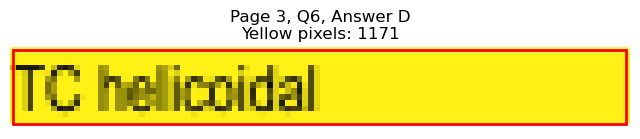


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=178.6, y1=543.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 537
Page 3, Q7, A: Yellow percentage: 0.0%


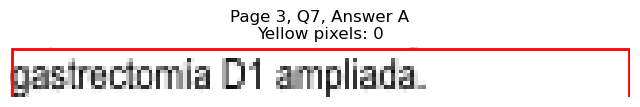

Page 3, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=197.3, y1=556.4
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 637
Page 3, Q7, B: Yellow percentage: 0.0%


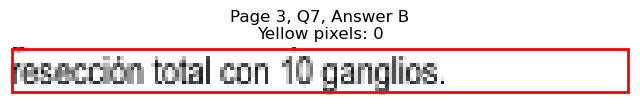

Page 3, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=398.7, y1=543.8
Page 3, Q7, C: Yellow pixels: 1331
Page 3, Q7, C: Total non-white pixels: 1586
Page 3, Q7, C: Yellow percentage: 83.9%


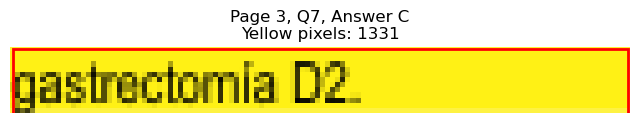

Page 3, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=496.2, y1=556.4
Page 3, Q7, D: Yellow pixels: 209
Page 3, Q7, D: Total non-white pixels: 1000
Page 3, Q7, D: Yellow percentage: 20.9%


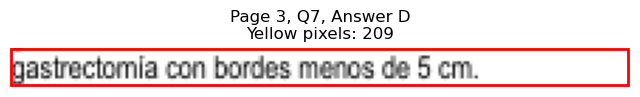


Page 3, Q7 - Selected Answer: C (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=606.9, x1=151.1, y1=619.6
Page 3, Q8, A: Yellow pixels: 1403
Page 3, Q8, A: Total non-white pixels: 1876
Page 3, Q8, A: Yellow percentage: 74.8%


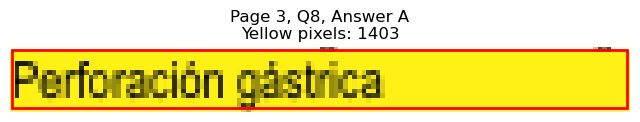

Page 3, Q8 - B: Detected box: x0=68.3, y0=619.6, x1=190.2, y1=632.3
Page 3, Q8, B: Yellow pixels: 172
Page 3, Q8, B: Total non-white pixels: 798
Page 3, Q8, B: Yellow percentage: 21.6%


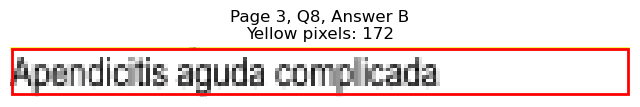

Page 3, Q8 - C: Detected box: x0=327.5, y0=606.9, x1=410.3, y1=619.6
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 432
Page 3, Q8, C: Yellow percentage: 0.0%


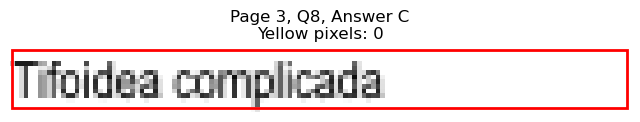

Page 3, Q8 - D: Detected box: x0=327.5, y0=619.6, x1=406.7, y1=632.3
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 413
Page 3, Q8, D: Yellow percentage: 0.0%


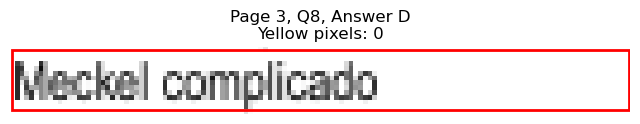


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=166.6, y1=670.1
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 463
Page 3, Q9, A: Yellow percentage: 0.0%


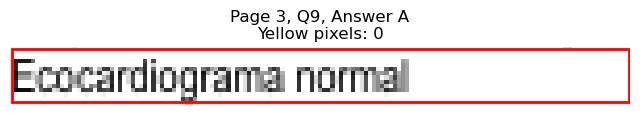

Page 3, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=213.3, y1=682.7
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 701
Page 3, Q9, B: Yellow percentage: 0.0%


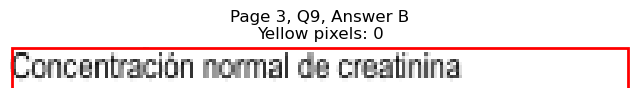

Page 3, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=452.9, y1=670.1
Page 3, Q9, C: Yellow pixels: 176
Page 3, Q9, C: Total non-white pixels: 795
Page 3, Q9, C: Yellow percentage: 22.1%


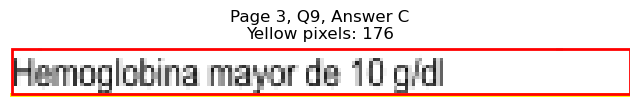

Page 3, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=462.4, y1=682.7
Page 3, Q9, D: Yellow pixels: 1896
Page 3, Q9, D: Total non-white pixels: 2418
Page 3, Q9, D: Yellow percentage: 78.4%


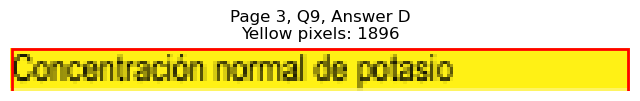


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=118.1, y1=720.6
Page 3, Q10, A: Yellow pixels: 1131
Page 3, Q10, A: Total non-white pixels: 1414
Page 3, Q10, A: Yellow percentage: 80.0%


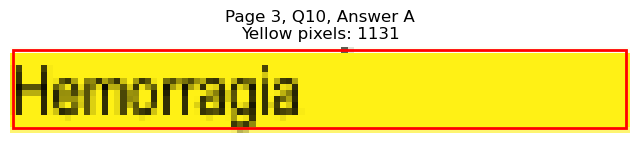

Page 3, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=160.7, y1=733.2
Page 3, Q10, B: Yellow pixels: 141
Page 3, Q10, B: Total non-white pixels: 582
Page 3, Q10, B: Yellow percentage: 24.2%


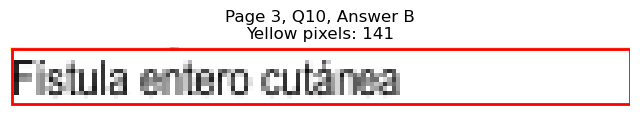

Page 3, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=442.9, y1=720.6
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 632
Page 3, Q10, C: Yellow percentage: 0.0%


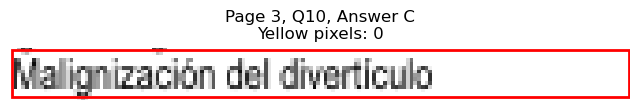

Page 3, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=476.0, y1=733.2
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 739
Page 3, Q10, D: Yellow percentage: 0.0%


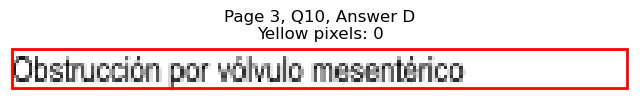


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=178.7, y1=102.1
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 568
Page 4, Q1, A: Yellow percentage: 0.0%


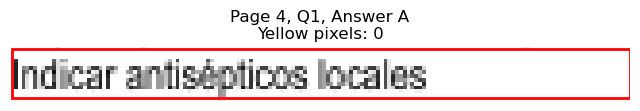

Page 4, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=179.2, y1=114.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 551
Page 4, Q1, B: Yellow percentage: 0.0%


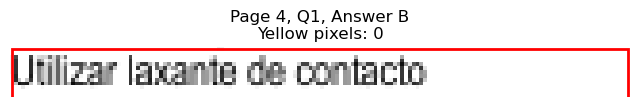

Page 4, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=424.9, y1=102.1
Page 4, Q1, C: Yellow pixels: 148
Page 4, Q1, C: Total non-white pixels: 643
Page 4, Q1, C: Yellow percentage: 23.0%


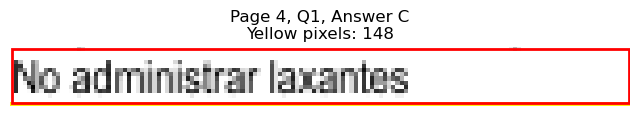

Page 4, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=418.3, y1=114.7
Page 4, Q1, D: Yellow pixels: 1498
Page 4, Q1, D: Total non-white pixels: 1846
Page 4, Q1, D: Yellow percentage: 81.1%


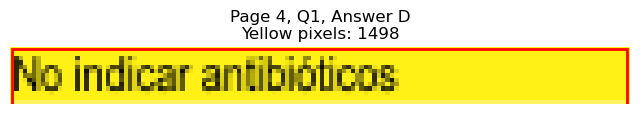


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=111.4, y1=152.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 235
Page 4, Q2, A: Yellow percentage: 0.0%


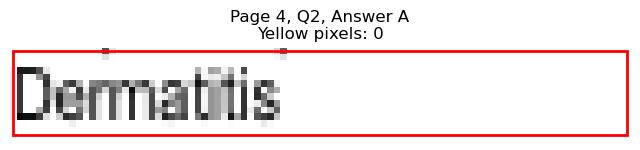

Page 4, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=148.6, y1=165.2
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 410
Page 4, Q2, B: Yellow percentage: 0.0%


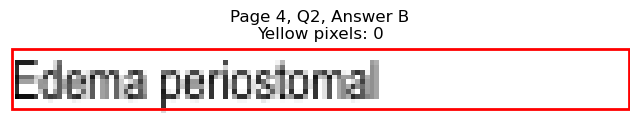

Page 4, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=455.5, y1=152.6
Page 4, Q2, C: Yellow pixels: 1845
Page 4, Q2, C: Total non-white pixels: 2506
Page 4, Q2, C: Yellow percentage: 73.6%


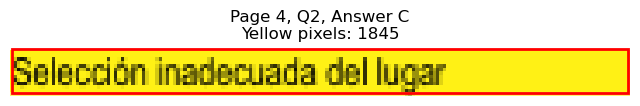

Page 4, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=461.5, y1=165.2
Page 4, Q2, D: Yellow pixels: 184
Page 4, Q2, D: Total non-white pixels: 861
Page 4, Q2, D: Yellow percentage: 21.4%


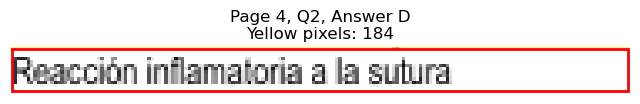


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=204.6, y1=253.5
Page 4, Q3, A: Yellow pixels: 187
Page 4, Q3, A: Total non-white pixels: 870
Page 4, Q3, A: Yellow percentage: 21.5%


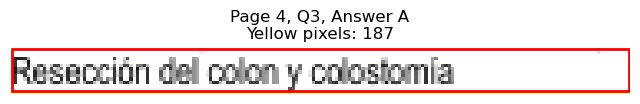

Page 4, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=202.7, y1=266.1
Page 4, Q3, B: Yellow pixels: 1866
Page 4, Q3, B: Total non-white pixels: 2590
Page 4, Q3, B: Yellow percentage: 72.0%


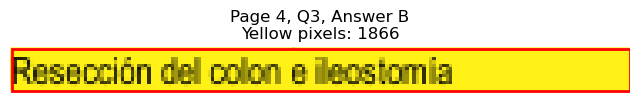

Page 4, Q3 - C: Detected box: x0=68.8, y0=266.1, x1=201.2, y1=278.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 858
Page 4, Q3, C: Yellow percentage: 0.0%


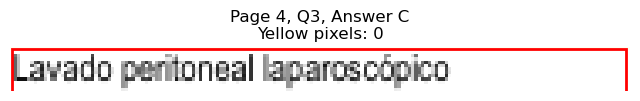

Page 4, Q3 - D: Detected box: x0=68.8, y0=278.8, x1=152.5, y1=291.5
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 443
Page 4, Q3, D: Yellow percentage: 0.0%


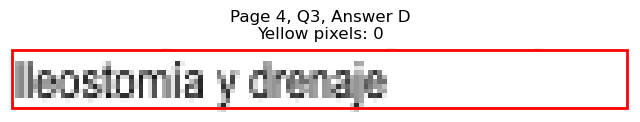


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=117.5, y1=354.6
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 250
Page 4, Q4, A: Yellow percentage: 0.0%


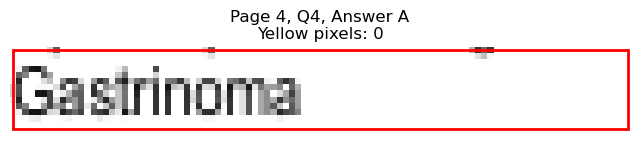

Page 4, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=127.0, y1=367.2
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 299
Page 4, Q4, B: Yellow percentage: 0.0%


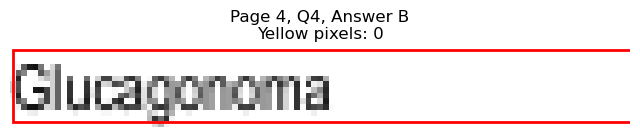

Page 4, Q4 - C: Detected box: x0=327.5, y0=341.9, x1=373.7, y1=354.6
Page 4, Q4, C: Yellow pixels: 1091
Page 4, Q4, C: Total non-white pixels: 1358
Page 4, Q4, C: Yellow percentage: 80.3%


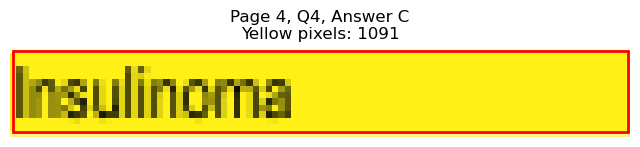

Page 4, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=400.3, y1=367.2
Page 4, Q4, D: Yellow pixels: 124
Page 4, Q4, D: Total non-white pixels: 499
Page 4, Q4, D: Yellow percentage: 24.8%


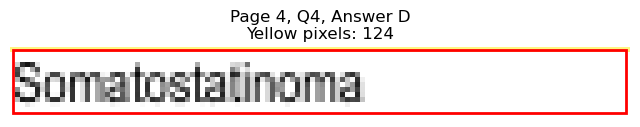


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=158.5, y1=430.3
Page 4, Q5, A: Yellow pixels: 141
Page 4, Q5, A: Total non-white pixels: 625
Page 4, Q5, A: Yellow percentage: 22.6%


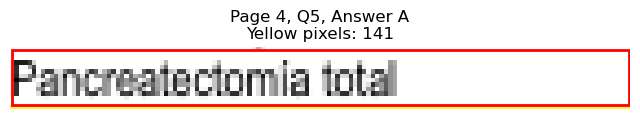

Page 4, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=131.5, y1=442.9
Page 4, Q5, B: Yellow pixels: 1232
Page 4, Q5, B: Total non-white pixels: 1482
Page 4, Q5, B: Yellow percentage: 83.1%


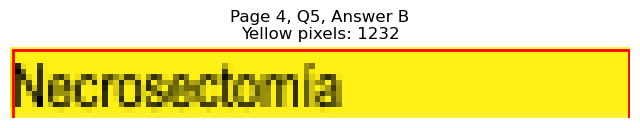

Page 4, Q5 - C: Detected box: x0=327.5, y0=417.6, x1=391.7, y1=430.3
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 343
Page 4, Q5, C: Yellow percentage: 0.0%


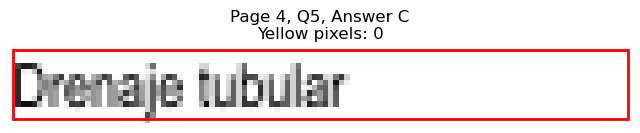

Page 4, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=457.5, y1=442.9
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 666
Page 4, Q5, D: Yellow percentage: 0.0%


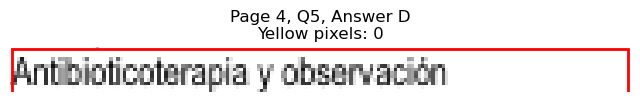


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=506.0, x1=194.2, y1=518.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 648
Page 4, Q6, A: Yellow percentage: 0.0%


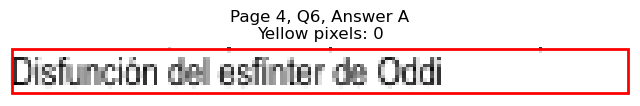

Page 4, Q6 - B: Detected box: x0=68.3, y0=518.6, x1=148.0, y1=531.2
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 416
Page 4, Q6, B: Yellow percentage: 0.0%


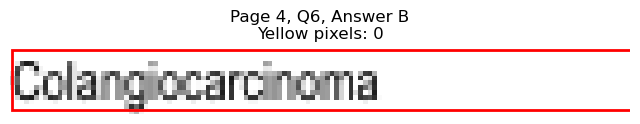

Page 4, Q6 - C: Detected box: x0=327.5, y0=506.0, x1=458.5, y1=518.6
Page 4, Q6, C: Yellow pixels: 1830
Page 4, Q6, C: Total non-white pixels: 2548
Page 4, Q6, C: Yellow percentage: 71.8%


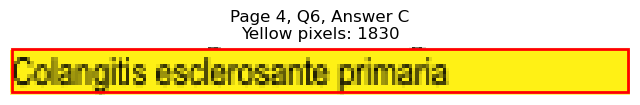

Page 4, Q6 - D: Detected box: x0=327.5, y0=518.6, x1=415.3, y1=531.2
Page 4, Q6, D: Yellow pixels: 138
Page 4, Q6, D: Total non-white pixels: 582
Page 4, Q6, D: Yellow percentage: 23.7%


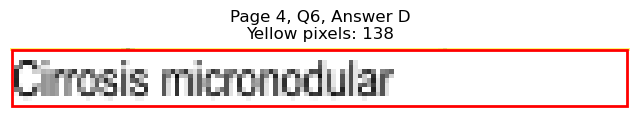


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=137.1, y1=581.8
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 352
Page 4, Q7, A: Yellow percentage: 0.0%


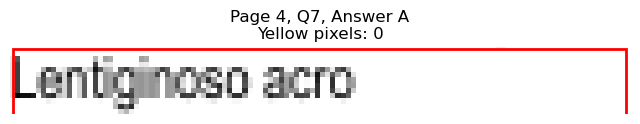

Page 4, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=134.5, y1=594.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 353
Page 4, Q7, B: Yellow percentage: 0.0%


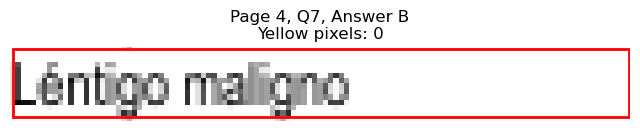

Page 4, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=361.6, y1=581.8
Page 4, Q7, C: Yellow pixels: 951
Page 4, Q7, C: Total non-white pixels: 1105
Page 4, Q7, C: Yellow percentage: 86.1%


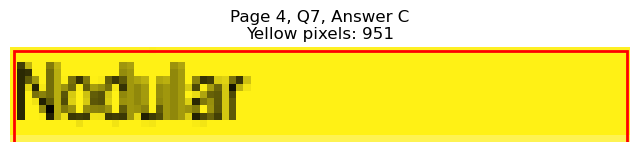

Page 4, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=412.9, y1=594.4
Page 4, Q7, D: Yellow pixels: 136
Page 4, Q7, D: Total non-white pixels: 580
Page 4, Q7, D: Yellow percentage: 23.4%


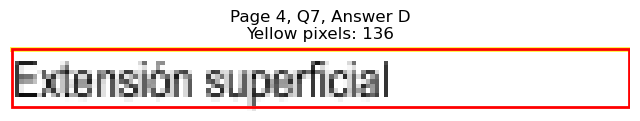


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=644.9, x1=124.5, y1=657.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 293
Page 4, Q8, A: Yellow percentage: 0.0%


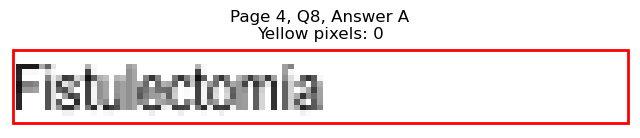

Page 4, Q8 - B: Detected box: x0=68.3, y0=657.5, x1=215.8, y1=670.1
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 727
Page 4, Q8, B: Yellow percentage: 0.0%


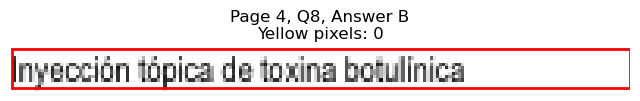

Page 4, Q8 - C: Detected box: x0=327.5, y0=644.9, x1=541.2, y1=657.5
Page 4, Q8, C: Yellow pixels: 213
Page 4, Q8, C: Total non-white pixels: 1290
Page 4, Q8, C: Yellow percentage: 16.5%


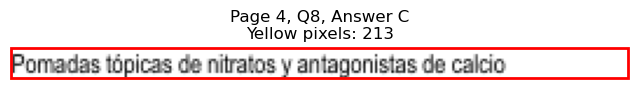

Page 4, Q8 - D: Detected box: x0=327.5, y0=657.5, x1=445.4, y1=670.1
Page 4, Q8, D: Yellow pixels: 1731
Page 4, Q8, D: Total non-white pixels: 2366
Page 4, Q8, D: Yellow percentage: 73.2%


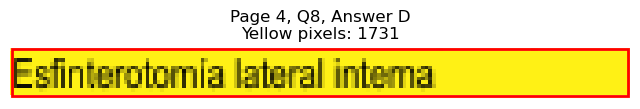


Page 4, Q8 - Selected Answer: D (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=169.1, y1=708.0
Page 4, Q9, A: Yellow pixels: 152
Page 4, Q9, A: Total non-white pixels: 823
Page 4, Q9, A: Yellow percentage: 18.5%


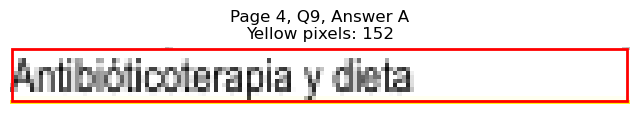

Page 4, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=227.3, y1=720.6
Page 4, Q9, B: Yellow pixels: 2130
Page 4, Q9, B: Total non-white pixels: 2940
Page 4, Q9, B: Yellow percentage: 72.4%


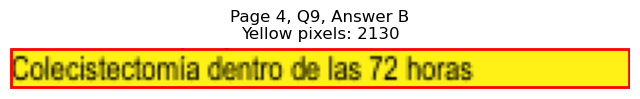

Page 4, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=464.9, y1=708.0
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 704
Page 4, Q9, C: Yellow percentage: 0.0%


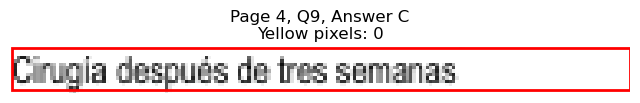

Page 4, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=476.6, y1=720.6
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 787
Page 4, Q9, D: Yellow percentage: 0.0%


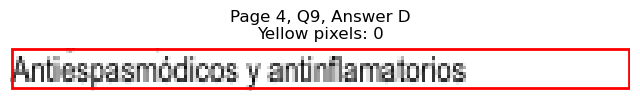


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=745.8, x1=146.1, y1=758.4
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 398
Page 4, Q10, A: Yellow percentage: 0.0%


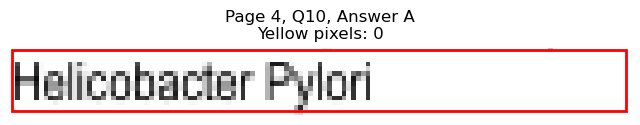

Page 4, Q10 - B: Detected box: x0=68.3, y0=758.5, x1=89.4, y1=771.2
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 101
Page 4, Q10, B: Yellow percentage: 0.0%


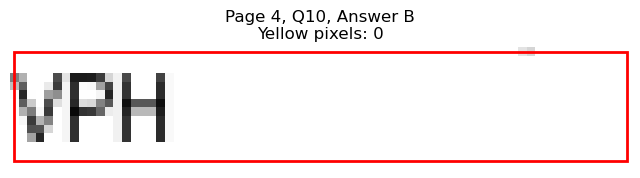

Page 4, Q10 - C: Detected box: x0=327.5, y0=745.8, x1=450.4, y1=758.4
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 594
Page 4, Q10, C: Yellow percentage: 0.0%


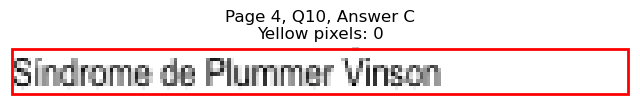

Page 4, Q10 - D: Detected box: x0=327.5, y0=758.5, x1=366.3, y1=771.2
Page 4, Q10, D: Yellow pixels: 1000
Page 4, Q10, D: Total non-white pixels: 1260
Page 4, Q10, D: Yellow percentage: 79.4%


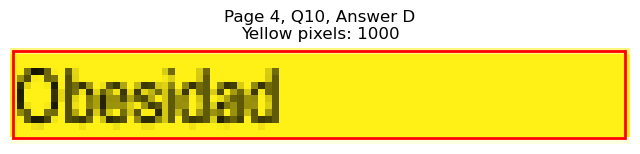


Page 4, Q10 - Selected Answer: D (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=224.2, y1=102.1
Page 5, Q1, A: Yellow pixels: 2076
Page 5, Q1, A: Total non-white pixels: 2898
Page 5, Q1, A: Yellow percentage: 71.6%


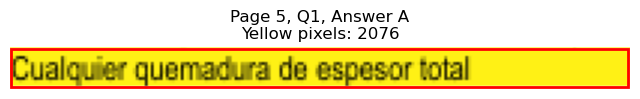

Page 5, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=312.5, y1=114.7
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 1494
Page 5, Q1, B: Yellow percentage: 0.0%


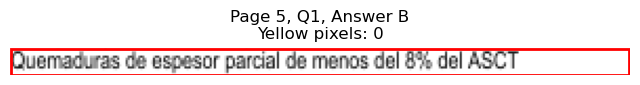

Page 5, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=241.2, y1=127.3
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 799
Page 5, Q1, C: Yellow percentage: 0.0%


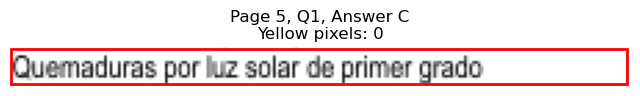

Page 5, Q1 - D: Detected box: x0=68.8, y0=127.2, x1=289.0, y1=139.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 1111
Page 5, Q1, D: Yellow percentage: 0.0%


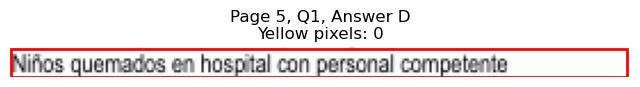


Page 5, Q1 - Selected Answer: A (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=150.0, y1=203.0
Page 5, Q2, A: Yellow pixels: 1429
Page 5, Q2, A: Total non-white pixels: 1729
Page 5, Q2, A: Yellow percentage: 82.6%


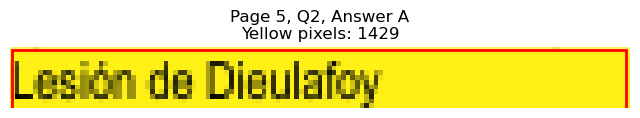

Page 5, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=162.6, y1=215.6
Page 5, Q2, B: Yellow pixels: 143
Page 5, Q2, B: Total non-white pixels: 632
Page 5, Q2, B: Yellow percentage: 22.6%


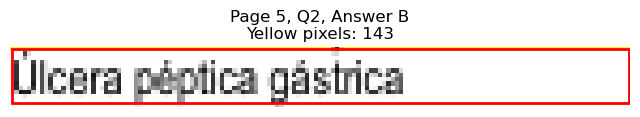

Page 5, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=423.3, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 483
Page 5, Q2, C: Yellow percentage: 0.0%


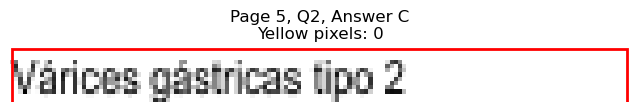

Page 5, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=432.3, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 550
Page 5, Q2, D: Yellow percentage: 0.0%


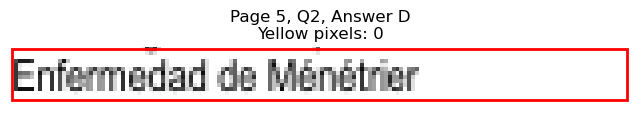


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=142.6, y1=253.5
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 391
Page 5, Q3, A: Yellow percentage: 0.0%


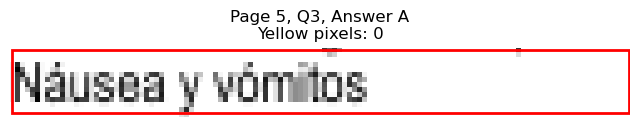

Page 5, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=150.0, y1=266.1
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 404
Page 5, Q3, B: Yellow percentage: 0.0%


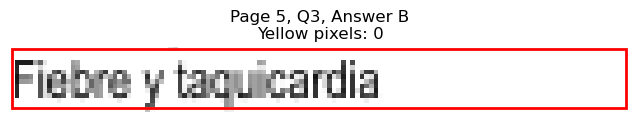

Page 5, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=464.0, y1=253.5
Page 5, Q3, C: Yellow pixels: 1921
Page 5, Q3, C: Total non-white pixels: 2618
Page 5, Q3, C: Yellow percentage: 73.4%


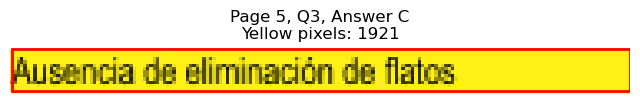

Page 5, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=441.4, y1=266.1
Page 5, Q3, D: Yellow pixels: 165
Page 5, Q3, D: Total non-white pixels: 761
Page 5, Q3, D: Yellow percentage: 21.7%


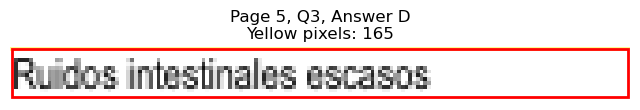


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=159.6, y1=329.3
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 450
Page 5, Q4, A: Yellow percentage: 0.0%


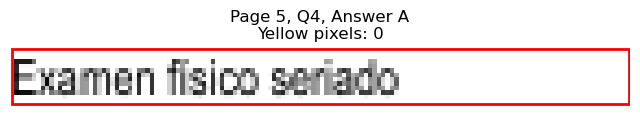

Page 5, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=93.9, y1=341.9
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 107
Page 5, Q4, B: Yellow percentage: 0.0%


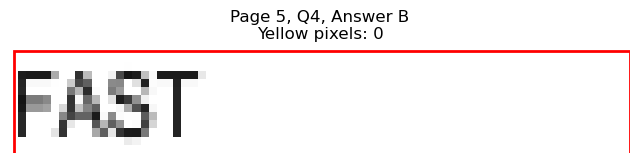

Page 5, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=432.9, y1=329.3
Page 5, Q4, C: Yellow pixels: 156
Page 5, Q4, C: Total non-white pixels: 693
Page 5, Q4, C: Yellow percentage: 22.5%


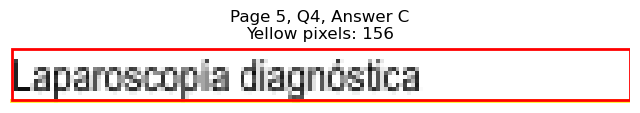

Page 5, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=447.9, y1=341.9
Page 5, Q4, D: Yellow pixels: 1747
Page 5, Q4, D: Total non-white pixels: 2223
Page 5, Q4, D: Yellow percentage: 78.6%


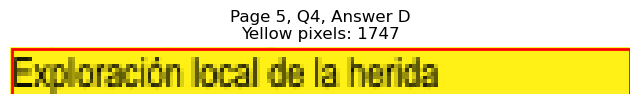


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=160.1, y1=379.8
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 437
Page 5, Q5, A: Yellow percentage: 0.0%


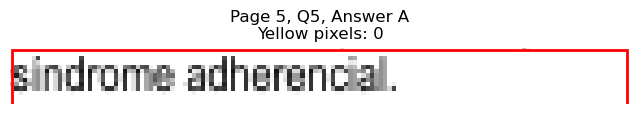

Page 5, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=195.3, y1=392.4
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 603
Page 5, Q5, B: Yellow percentage: 0.0%


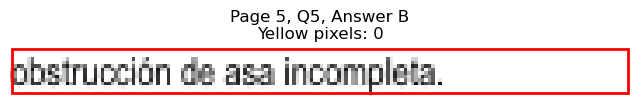

Page 5, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=419.8, y1=379.8
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 571
Page 5, Q5, C: Yellow percentage: 0.0%


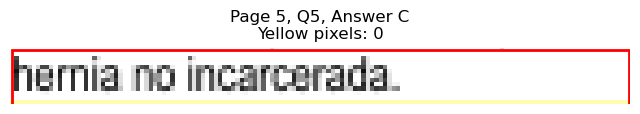

Page 5, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=500.1, y1=392.4
Page 5, Q5, D: Yellow pixels: 1867
Page 5, Q5, D: Total non-white pixels: 2996
Page 5, Q5, D: Yellow percentage: 62.3%


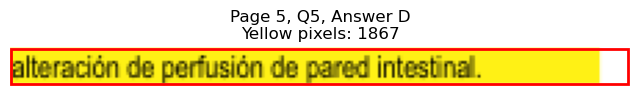


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=118.0, y1=430.3
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 261
Page 5, Q6, A: Yellow percentage: 0.0%


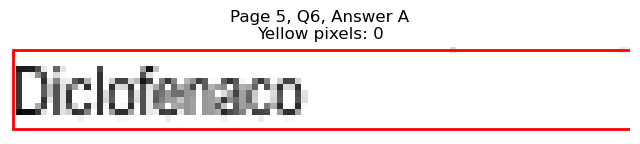

Page 5, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=121.5, y1=442.9
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 276
Page 5, Q6, B: Yellow percentage: 0.0%


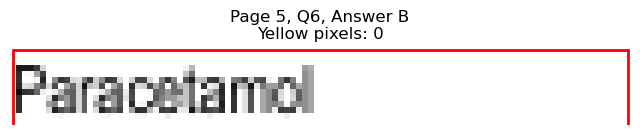

Page 5, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=377.7, y1=430.3
Page 5, Q6, C: Yellow pixels: 1011
Page 5, Q6, C: Total non-white pixels: 1414
Page 5, Q6, C: Yellow percentage: 71.5%


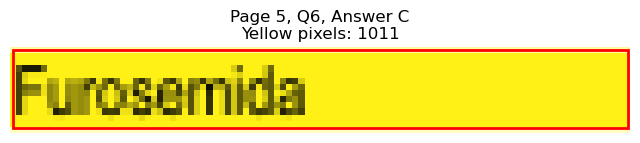

Page 5, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=387.2, y1=442.9
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 425
Page 5, Q6, D: Yellow percentage: 0.0%


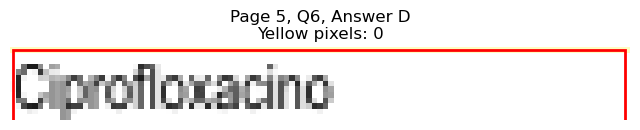


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=193.2, y1=493.4
Page 5, Q7, A: Yellow pixels: 1624
Page 5, Q7, A: Total non-white pixels: 2464
Page 5, Q7, A: Yellow percentage: 65.9%


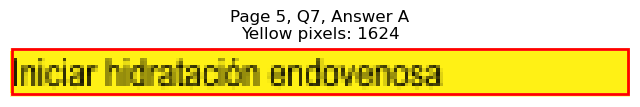

Page 5, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=255.5, y1=506.0
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 1130
Page 5, Q7, B: Yellow percentage: 0.0%


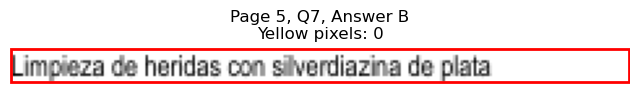

Page 5, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=498.1, y1=493.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 874
Page 5, Q7, C: Yellow percentage: 0.0%


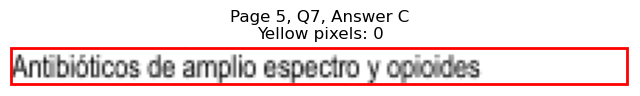

Page 5, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=426.9, y1=506.0
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 514
Page 5, Q7, D: Yellow percentage: 0.0%


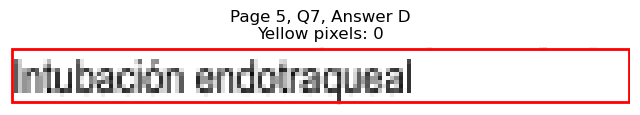


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=118.0, y1=543.8
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 236
Page 5, Q8, A: Yellow percentage: 0.0%


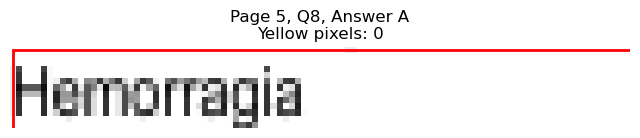

Page 5, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=97.9, y1=556.4
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 172
Page 5, Q8, B: Yellow percentage: 0.0%


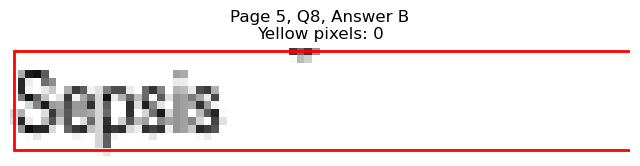

Page 5, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=369.7, y1=543.8
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 310
Page 5, Q8, C: Yellow percentage: 0.0%


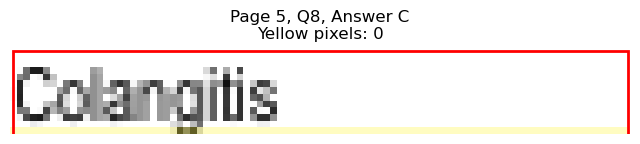

Page 5, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=390.8, y1=556.4
Page 5, Q8, D: Yellow pixels: 1221
Page 5, Q8, D: Total non-white pixels: 1596
Page 5, Q8, D: Yellow percentage: 76.5%


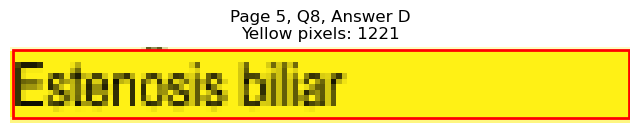


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=352.1, y1=594.4
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 1383
Page 5, Q9, A: Yellow percentage: 0.0%


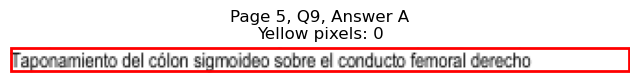

Page 5, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=231.9, y1=607.0
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 788
Page 5, Q9, B: Yellow percentage: 0.0%


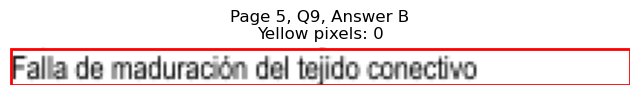

Page 5, Q9 - C: Detected box: x0=68.8, y0=606.9, x1=192.6, y1=619.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 627
Page 5, Q9, C: Yellow percentage: 0.0%


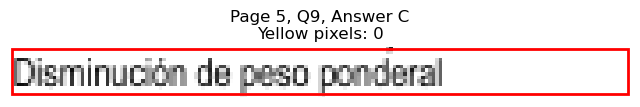

Page 5, Q9 - D: Detected box: x0=68.8, y0=619.6, x1=277.6, y1=632.3
Page 5, Q9, D: Yellow pixels: 2328
Page 5, Q9, D: Total non-white pixels: 3640
Page 5, Q9, D: Yellow percentage: 64.0%


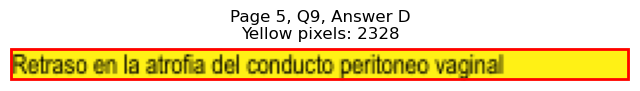


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=174.6, y1=682.7
Page 5, Q10, A: Yellow pixels: 1
Page 5, Q10, A: Total non-white pixels: 688
Page 5, Q10, A: Yellow percentage: 0.1%


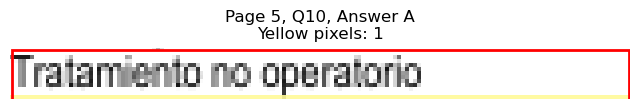

Page 5, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=171.1, y1=695.3
Page 5, Q10, B: Yellow pixels: 1446
Page 5, Q10, B: Total non-white pixels: 2156
Page 5, Q10, B: Yellow percentage: 67.1%


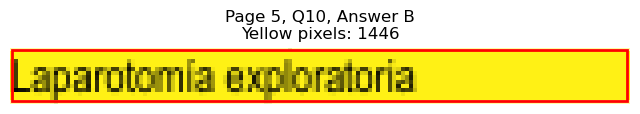

Page 5, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=353.1, y1=682.7
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 116
Page 5, Q10, C: Yellow percentage: 0.0%


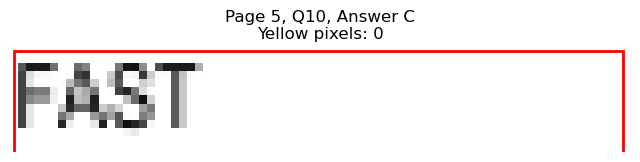

Page 5, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=420.3, y1=695.3
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 476
Page 5, Q10, D: Yellow percentage: 0.0%


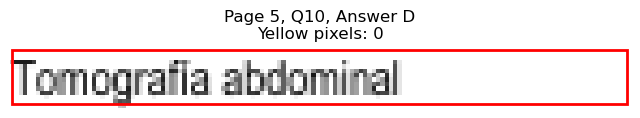


Page 5, Q10 - Selected Answer: B (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=177.6, y1=758.4
Page 5, Q11, A: Yellow pixels: 0
Page 5, Q11, A: Total non-white pixels: 554
Page 5, Q11, A: Yellow percentage: 0.0%


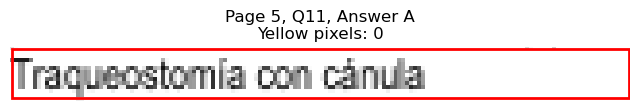

Page 5, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=169.2, y1=771.2
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 547
Page 5, Q11, B: Yellow percentage: 0.0%


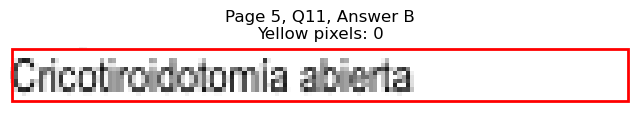

Page 5, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=427.0, y1=758.4
Page 5, Q11, C: Yellow pixels: 1567
Page 5, Q11, C: Total non-white pixels: 2114
Page 5, Q11, C: Yellow percentage: 74.1%


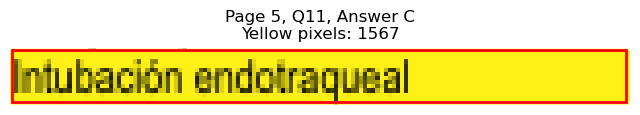

Page 5, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=436.0, y1=771.2
Page 5, Q11, D: Yellow pixels: 159
Page 5, Q11, D: Total non-white pixels: 730
Page 5, Q11, D: Yellow percentage: 21.8%


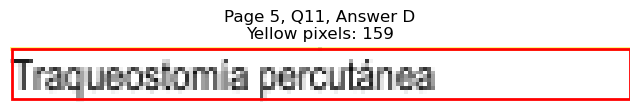


Page 5, Q11 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=157.1, y1=102.1
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 499
Page 6, Q1, A: Yellow percentage: 0.0%


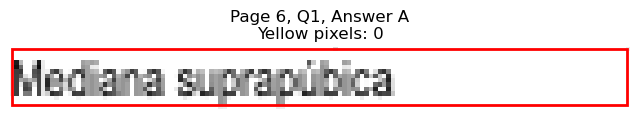

Page 6, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=176.2, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 582
Page 6, Q1, B: Yellow percentage: 0.0%


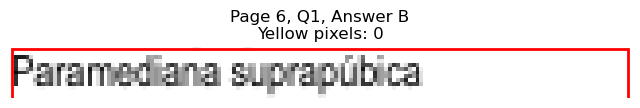

Page 6, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=438.9, y1=102.1
Page 6, Q1, C: Yellow pixels: 162
Page 6, Q1, C: Total non-white pixels: 749
Page 6, Q1, C: Yellow percentage: 21.6%


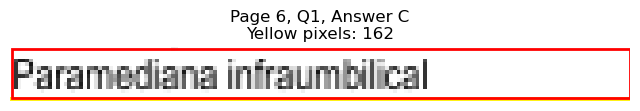

Page 6, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=407.8, y1=114.7
Page 6, Q1, D: Yellow pixels: 1374
Page 6, Q1, D: Total non-white pixels: 1703
Page 6, Q1, D: Yellow percentage: 80.7%


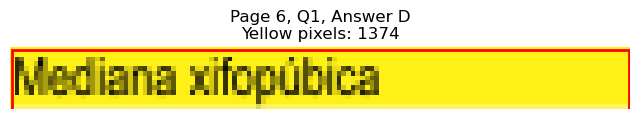


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=141.5, y1=177.8
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 524
Page 6, Q2, A: Yellow percentage: 0.0%


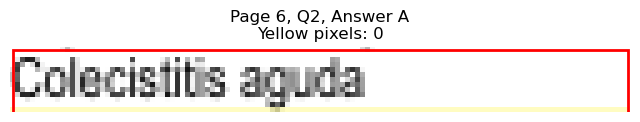

Page 6, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=133.5, y1=190.4
Page 6, Q2, B: Yellow pixels: 1111
Page 6, Q2, B: Total non-white pixels: 1624
Page 6, Q2, B: Yellow percentage: 68.4%


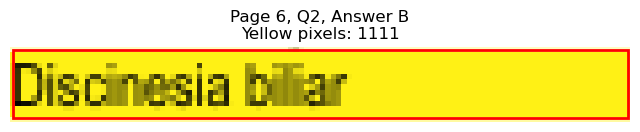

Page 6, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=408.8, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 409
Page 6, Q2, C: Yellow percentage: 0.0%


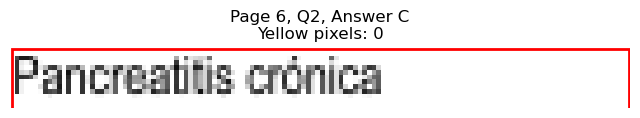

Page 6, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=397.3, y1=190.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 372
Page 6, Q2, D: Yellow percentage: 0.0%


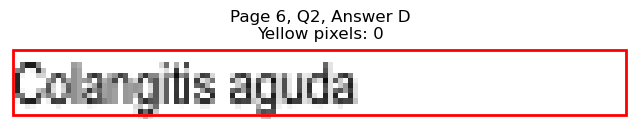


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=234.3, y1=253.5
Page 6, Q3, A: Yellow pixels: 2145
Page 6, Q3, A: Total non-white pixels: 2996
Page 6, Q3, A: Yellow percentage: 71.6%


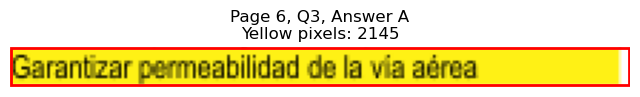

Page 6, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=202.2, y1=266.1
Page 6, Q3, B: Yellow pixels: 185
Page 6, Q3, B: Total non-white pixels: 829
Page 6, Q3, B: Yellow percentage: 22.3%


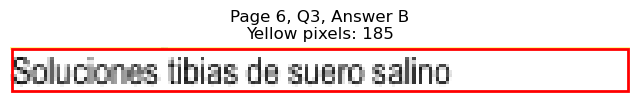

Page 6, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=453.4, y1=253.5
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 622
Page 6, Q3, C: Yellow percentage: 0.0%


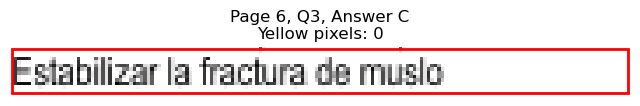

Page 6, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=482.0, y1=266.1
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 741
Page 6, Q3, D: Yellow percentage: 0.0%


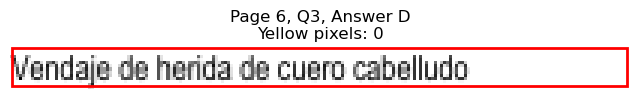


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=244.8, y1=304.1
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 867
Page 6, Q4, A: Yellow percentage: 0.0%


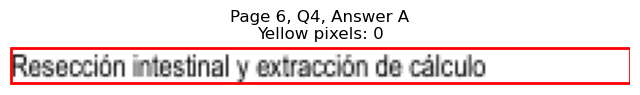

Page 6, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=217.8, y1=316.7
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 729
Page 6, Q4, B: Yellow percentage: 0.0%


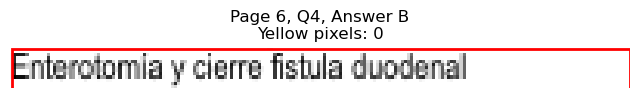

Page 6, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=480.1, y1=304.1
Page 6, Q4, C: Yellow pixels: 204
Page 6, Q4, C: Total non-white pixels: 956
Page 6, Q4, C: Yellow percentage: 21.3%


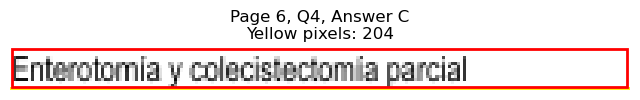

Page 6, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=473.1, y1=316.7
Page 6, Q4, D: Yellow pixels: 2011
Page 6, Q4, D: Total non-white pixels: 2561
Page 6, Q4, D: Yellow percentage: 78.5%


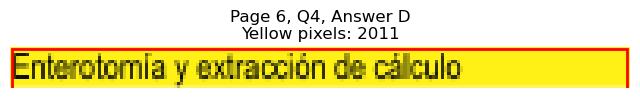


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=184.7, y1=379.8
Page 6, Q5, A: Yellow pixels: 1726
Page 6, Q5, A: Total non-white pixels: 2171
Page 6, Q5, A: Yellow percentage: 79.5%


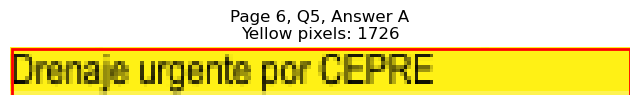

Page 6, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=121.6, y1=392.4
Page 6, Q5, B: Yellow pixels: 101
Page 6, Q5, B: Total non-white pixels: 379
Page 6, Q5, B: Yellow percentage: 26.6%


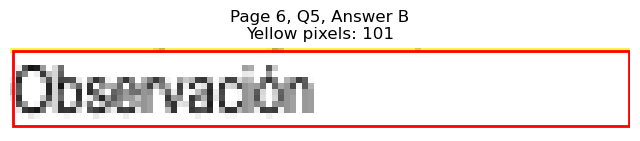

Page 6, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=466.0, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 691
Page 6, Q5, C: Yellow percentage: 0.0%


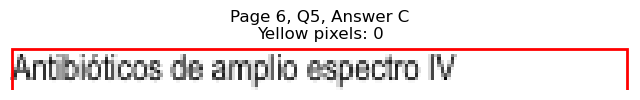

Page 6, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=392.2, y1=392.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 352
Page 6, Q5, D: Yellow percentage: 0.0%


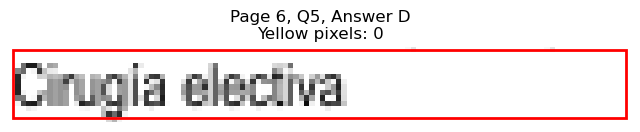


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=161.1, y1=468.1
Page 6, Q6, A: Yellow pixels: 1522
Page 6, Q6, A: Total non-white pixels: 2016
Page 6, Q6, A: Yellow percentage: 75.5%


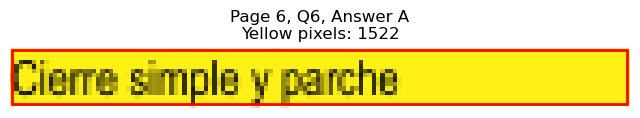

Page 6, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=202.2, y1=480.7
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 884
Page 6, Q6, B: Yellow percentage: 0.0%


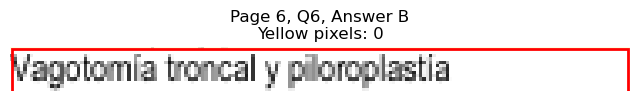

Page 6, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=431.5, y1=468.1
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 544
Page 6, Q6, C: Yellow percentage: 0.0%


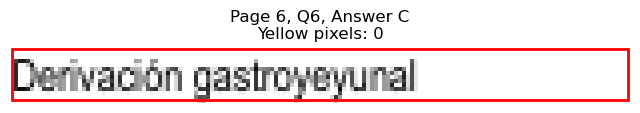

Page 6, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=433.9, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 568
Page 6, Q6, D: Yellow percentage: 0.0%


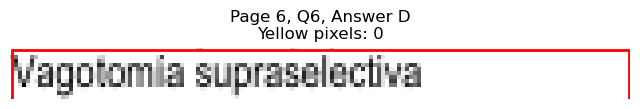


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=186.1, y1=531.2
Page 6, Q7, A: Yellow pixels: 1758
Page 6, Q7, A: Total non-white pixels: 2366
Page 6, Q7, A: Yellow percentage: 74.3%


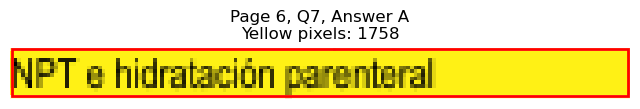

Page 6, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=300.0, y1=543.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 1457
Page 6, Q7, B: Yellow percentage: 0.0%


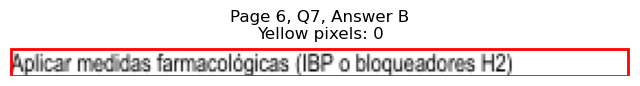

Page 6, Q7 - C: Detected box: x0=68.8, y0=543.8, x1=234.8, y1=556.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 841
Page 6, Q7, C: Yellow percentage: 0.0%


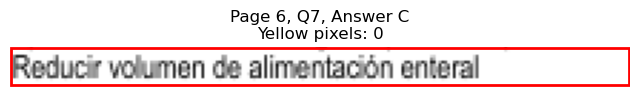

Page 6, Q7 - D: Detected box: x0=68.8, y0=556.5, x1=224.8, y1=569.2
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 795
Page 6, Q7, D: Yellow percentage: 0.0%


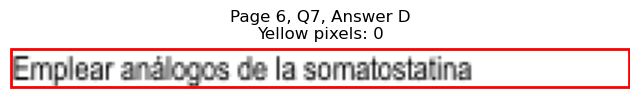


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=594.3, x1=167.7, y1=607.0
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 508
Page 6, Q8, A: Yellow percentage: 0.0%


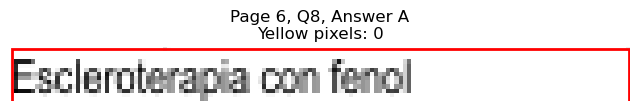

Page 6, Q8 - B: Detected box: x0=68.3, y0=606.9, x1=186.6, y1=619.6
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 591
Page 6, Q8, B: Yellow percentage: 0.0%


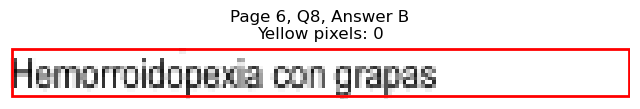

Page 6, Q8 - C: Detected box: x0=327.5, y0=594.3, x1=455.0, y1=607.0
Page 6, Q8, C: Yellow pixels: 1837
Page 6, Q8, C: Total non-white pixels: 2314
Page 6, Q8, C: Yellow percentage: 79.4%


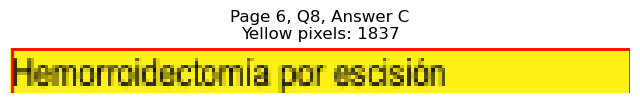

Page 6, Q8 - D: Detected box: x0=327.5, y0=606.9, x1=441.4, y1=619.6
Page 6, Q8, D: Yellow pixels: 163
Page 6, Q8, D: Total non-white pixels: 783
Page 6, Q8, D: Yellow percentage: 20.8%


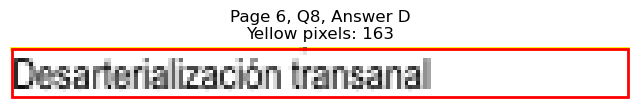


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=178.1, y1=657.5
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 539
Page 6, Q9, A: Yellow percentage: 0.0%


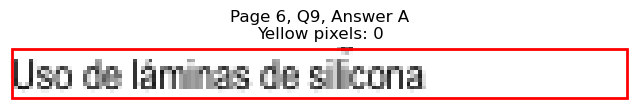

Page 6, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=172.6, y1=670.1
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 523
Page 6, Q9, B: Yellow percentage: 0.0%


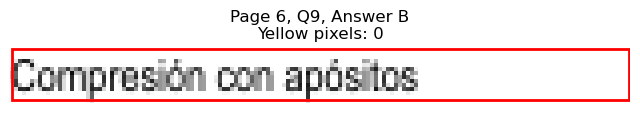

Page 6, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=452.0, y1=657.5
Page 6, Q9, C: Yellow pixels: 1800
Page 6, Q9, C: Total non-white pixels: 2450
Page 6, Q9, C: Yellow percentage: 73.5%


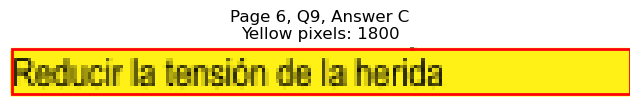

Page 6, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=413.3, y1=670.1
Page 6, Q9, D: Yellow pixels: 137
Page 6, Q9, D: Total non-white pixels: 579
Page 6, Q9, D: Yellow percentage: 23.7%


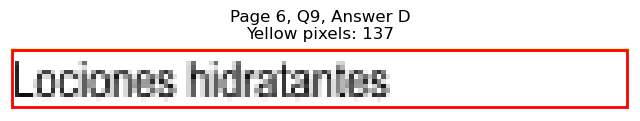


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=162.6, y1=733.2
Page 6, Q10, A: Yellow pixels: 145
Page 6, Q10, A: Total non-white pixels: 625
Page 6, Q10, A: Yellow percentage: 23.2%


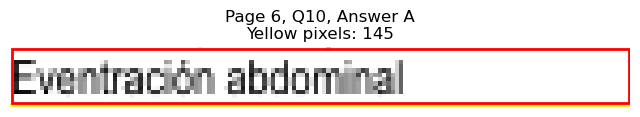

Page 6, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=142.6, y1=745.8
Page 6, Q10, B: Yellow pixels: 1319
Page 6, Q10, B: Total non-white pixels: 1625
Page 6, Q10, B: Yellow percentage: 81.2%


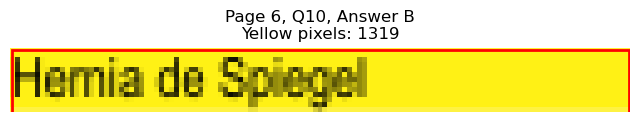

Page 6, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=419.8, y1=733.2
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 495
Page 6, Q10, C: Yellow percentage: 0.0%


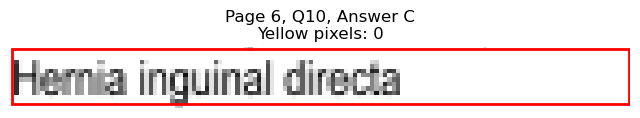

Page 6, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=403.8, y1=745.8
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 419
Page 6, Q10, D: Yellow percentage: 0.0%


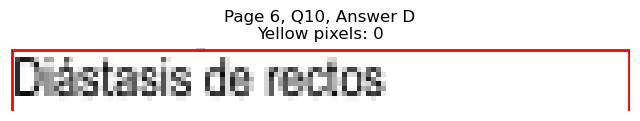


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=159.1, y1=127.3
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 456
Page 7, Q1, A: Yellow percentage: 0.0%


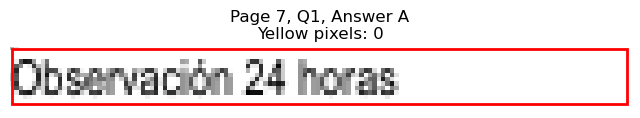

Page 7, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=193.7, y1=139.9
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 629
Page 7, Q1, B: Yellow percentage: 0.0%


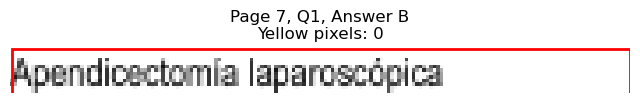

Page 7, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=432.9, y1=127.3
Page 7, Q1, C: Yellow pixels: 1486
Page 7, Q1, C: Total non-white pixels: 2184
Page 7, Q1, C: Yellow percentage: 68.0%


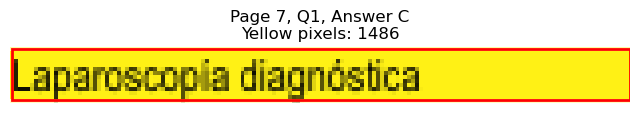

Page 7, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=430.9, y1=139.9
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 667
Page 7, Q1, D: Yellow percentage: 0.0%


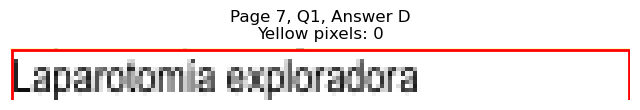


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=292.5, y1=177.8
Page 7, Q2, A: Yellow pixels: 2698
Page 7, Q2, A: Total non-white pixels: 3575
Page 7, Q2, A: Yellow percentage: 75.5%


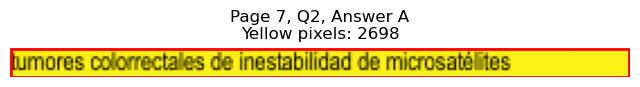

Page 7, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=260.3, y1=190.4
Page 7, Q2, B: Yellow pixels: 243
Page 7, Q2, B: Total non-white pixels: 1232
Page 7, Q2, B: Yellow percentage: 19.7%


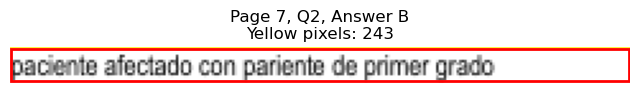

Page 7, Q2 - C: Detected box: x0=68.8, y0=190.3, x1=244.8, y1=203.0
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 907
Page 7, Q2, C: Yellow percentage: 0.0%


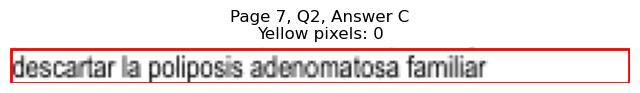

Page 7, Q2 - D: Detected box: x0=68.8, y0=202.9, x1=208.2, y1=215.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 734
Page 7, Q2, D: Yellow percentage: 0.0%


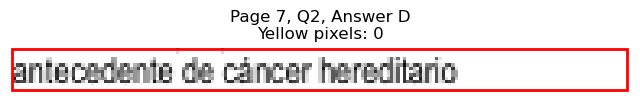


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=241.4, y1=266.1
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 873
Page 7, Q3, A: Yellow percentage: 0.0%


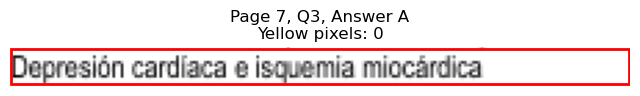

Page 7, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=195.7, y1=278.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 651
Page 7, Q3, B: Yellow percentage: 0.0%


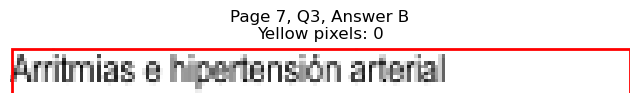

Page 7, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=515.6, y1=266.1
Page 7, Q3, C: Yellow pixels: 213
Page 7, Q3, C: Total non-white pixels: 1170
Page 7, Q3, C: Yellow percentage: 18.2%


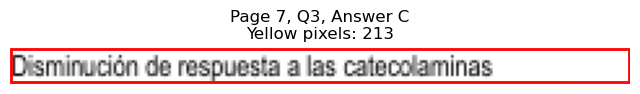

Page 7, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=537.3, y1=278.7
Page 7, Q3, D: Yellow pixels: 2023
Page 7, Q3, D: Total non-white pixels: 2782
Page 7, Q3, D: Yellow percentage: 72.7%


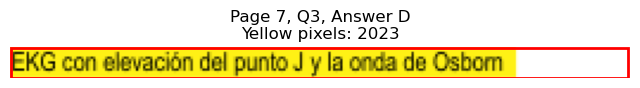


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=153.6, y1=341.9
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 444
Page 7, Q4, A: Yellow percentage: 0.0%


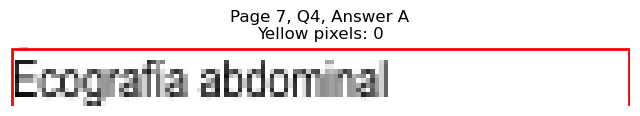

Page 7, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=95.9, y1=354.6
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 145
Page 7, Q4, B: Yellow percentage: 0.0%


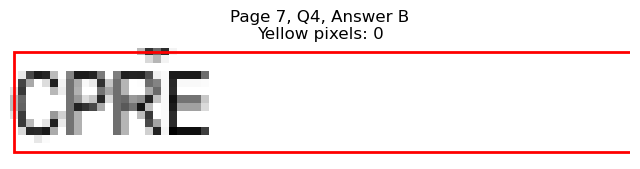

Page 7, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=412.3, y1=341.9
Page 7, Q4, C: Yellow pixels: 1425
Page 7, Q4, C: Total non-white pixels: 1768
Page 7, Q4, C: Yellow percentage: 80.6%


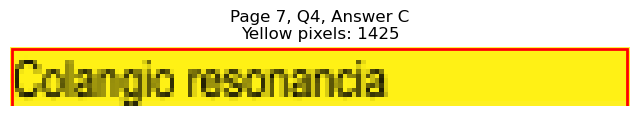

Page 7, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=420.3, y1=354.6
Page 7, Q4, D: Yellow pixels: 140
Page 7, Q4, D: Total non-white pixels: 623
Page 7, Q4, D: Yellow percentage: 22.5%


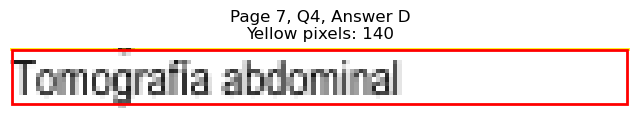


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=323.0, y1=392.4
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 1271
Page 7, Q5, A: Yellow percentage: 0.0%


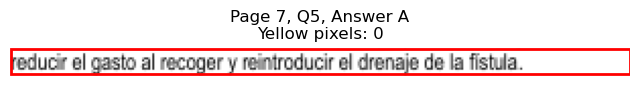

Page 7, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=195.7, y1=405.0
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 596
Page 7, Q5, B: Yellow percentage: 0.0%


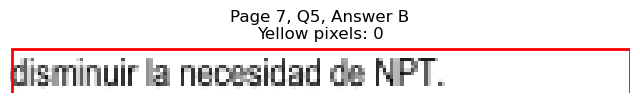

Page 7, Q5 - C: Detected box: x0=68.8, y0=404.9, x1=384.2, y1=417.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 1588
Page 7, Q5, C: Yellow percentage: 0.0%


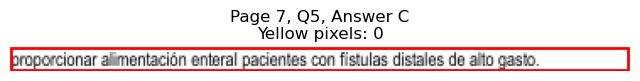

Page 7, Q5 - D: Detected box: x0=68.8, y0=417.6, x1=431.3, y1=430.3
Page 7, Q5, D: Yellow pixels: 3627
Page 7, Q5, D: Total non-white pixels: 5796
Page 7, Q5, D: Yellow percentage: 62.6%


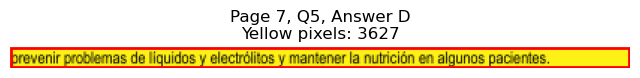


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=154.1, y1=468.1
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 420
Page 7, Q6, A: Yellow percentage: 0.0%


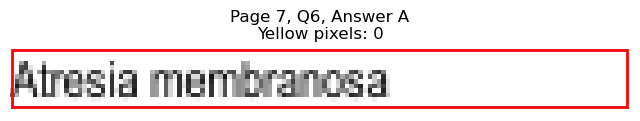

Page 7, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=127.9, y1=480.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 300
Page 7, Q6, B: Yellow percentage: 0.0%


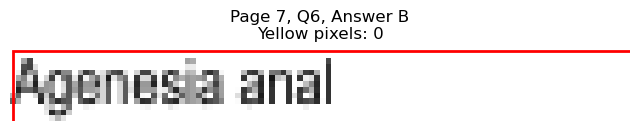

Page 7, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=388.7, y1=468.1
Page 7, Q6, C: Yellow pixels: 1218
Page 7, Q6, C: Total non-white pixels: 1568
Page 7, Q6, C: Yellow percentage: 77.7%


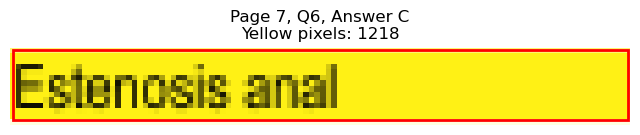

Page 7, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=410.3, y1=480.7
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 550
Page 7, Q6, D: Yellow percentage: 0.0%


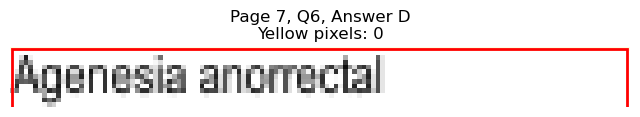


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=121.9, y1=531.2
Page 7, Q7, A: Yellow pixels: 104
Page 7, Q7, A: Total non-white pixels: 384
Page 7, Q7, A: Yellow percentage: 27.1%


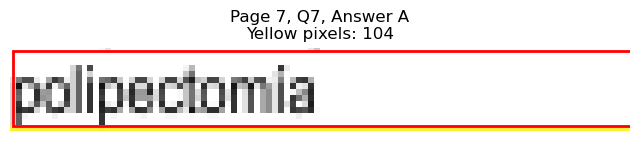

Page 7, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=166.6, y1=543.8
Page 7, Q7, B: Yellow pixels: 1521
Page 7, Q7, B: Total non-white pixels: 1937
Page 7, Q7, B: Yellow percentage: 78.5%


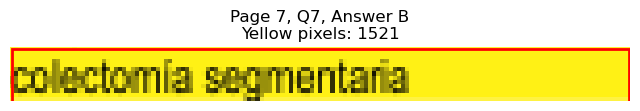

Page 7, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=383.2, y1=531.2
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 279
Page 7, Q7, C: Yellow percentage: 0.0%


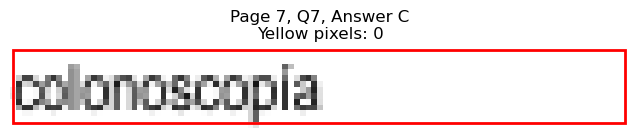

Page 7, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=393.3, y1=543.8
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 345
Page 7, Q7, D: Yellow percentage: 0.0%


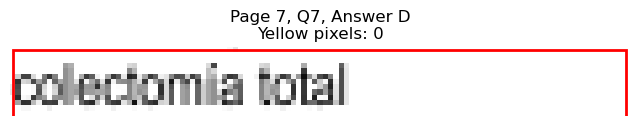


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=168.6, y1=581.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 516
Page 7, Q8, A: Yellow percentage: 0.0%


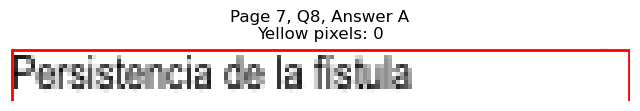

Page 7, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=179.7, y1=594.4
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 519
Page 7, Q8, B: Yellow percentage: 0.0%


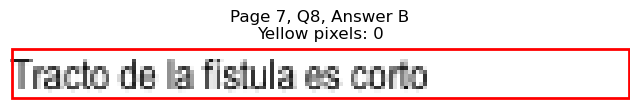

Page 7, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=378.7, y1=581.8
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 373
Page 7, Q8, C: Yellow percentage: 0.0%


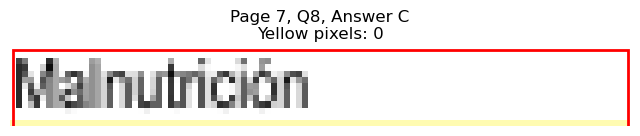

Page 7, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=421.9, y1=594.4
Page 7, Q8, D: Yellow pixels: 1374
Page 7, Q8, D: Total non-white pixels: 2030
Page 7, Q8, D: Yellow percentage: 67.7%


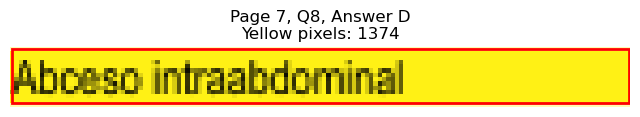


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=173.1, y1=670.1
Page 7, Q9, A: Yellow pixels: 156
Page 7, Q9, A: Total non-white pixels: 685
Page 7, Q9, A: Yellow percentage: 22.8%


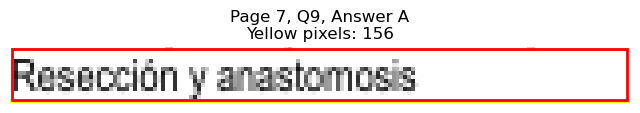

Page 7, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=191.7, y1=682.7
Page 7, Q9, B: Yellow pixels: 1795
Page 7, Q9, B: Total non-white pixels: 2262
Page 7, Q9, B: Yellow percentage: 79.4%


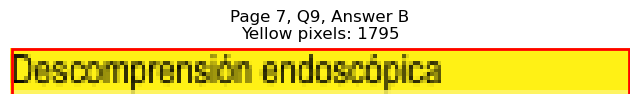

Page 7, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=442.4, y1=670.1
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 585
Page 7, Q9, C: Yellow percentage: 0.0%


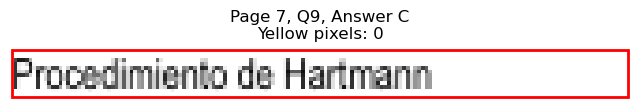

Page 7, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=434.3, y1=682.7
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 548
Page 7, Q9, D: Yellow percentage: 0.0%


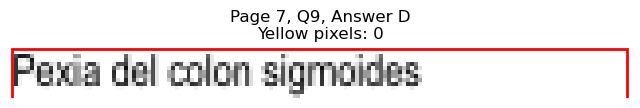


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=148.0, y1=720.6
Page 7, Q10, A: Yellow pixels: 130
Page 7, Q10, A: Total non-white pixels: 544
Page 7, Q10, A: Yellow percentage: 23.9%


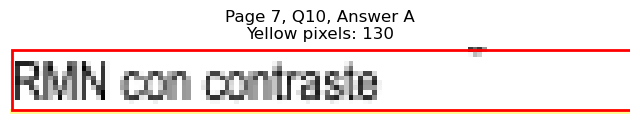

Page 7, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=175.6, y1=733.2
Page 7, Q10, B: Yellow pixels: 1629
Page 7, Q10, B: Total non-white pixels: 2212
Page 7, Q10, B: Yellow percentage: 73.6%


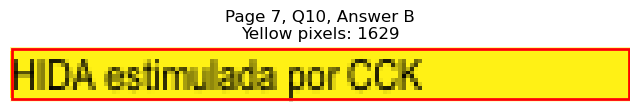

Page 7, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=405.8, y1=720.6
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 382
Page 7, Q10, C: Yellow percentage: 0.0%


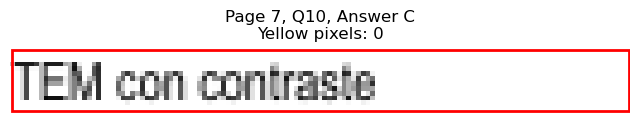

Page 7, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=429.3, y1=733.2
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 521
Page 7, Q10, D: Yellow percentage: 0.0%


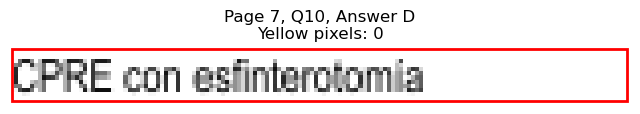


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=198.3, y1=127.3
Page 8, Q1, A: Yellow pixels: 181
Page 8, Q1, A: Total non-white pixels: 846
Page 8, Q1, A: Yellow percentage: 21.4%


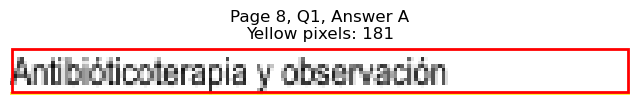

Page 8, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=227.3, y1=139.9
Page 8, Q1, B: Yellow pixels: 2089
Page 8, Q1, B: Total non-white pixels: 2730
Page 8, Q1, B: Yellow percentage: 76.5%


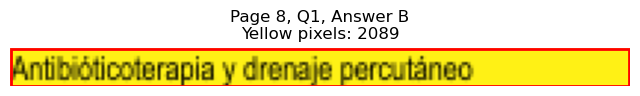

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=472.1, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 742
Page 8, Q1, C: Yellow percentage: 0.0%


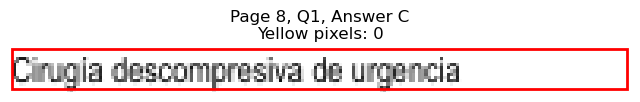

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=425.3, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 479
Page 8, Q1, D: Yellow percentage: 0.0%


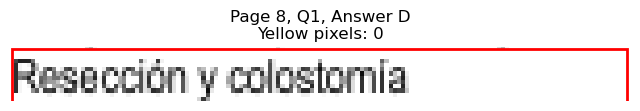


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=154.6, y1=190.4
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 415
Page 8, Q2, A: Yellow percentage: 0.0%


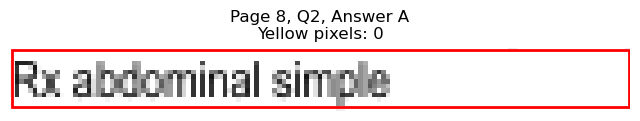

Page 8, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=136.5, y1=203.0
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 310
Page 8, Q2, B: Yellow percentage: 0.0%


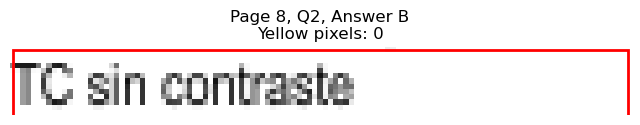

Page 8, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=530.1, y1=190.4
Page 8, Q2, C: Yellow pixels: 213
Page 8, Q2, C: Total non-white pixels: 1157
Page 8, Q2, C: Yellow percentage: 18.4%


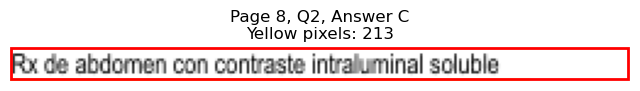

Page 8, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=414.9, y1=203.0
Page 8, Q2, D: Yellow pixels: 1504
Page 8, Q2, D: Total non-white pixels: 1794
Page 8, Q2, D: Yellow percentage: 83.8%


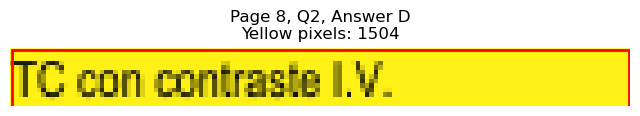


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=140.7, y1=240.9
Page 8, Q3, A: Yellow pixels: 1332
Page 8, Q3, A: Total non-white pixels: 1599
Page 8, Q3, A: Yellow percentage: 83.3%


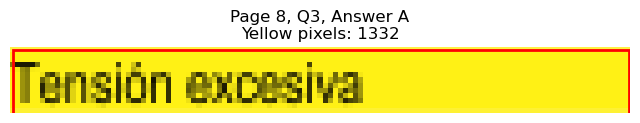

Page 8, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=148.6, y1=253.5
Page 8, Q3, B: Yellow pixels: 131
Page 8, Q3, B: Total non-white pixels: 497
Page 8, Q3, B: Yellow percentage: 26.4%


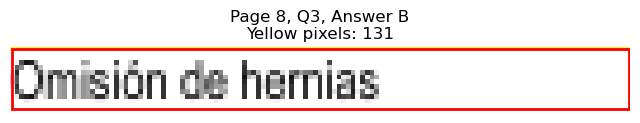

Page 8, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=491.7, y1=240.9
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 824
Page 8, Q3, C: Yellow percentage: 0.0%


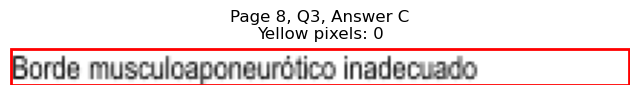

Page 8, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=458.5, y1=253.5
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 654
Page 8, Q3, D: Yellow percentage: 0.0%


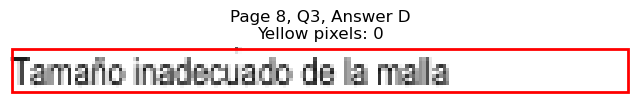


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=163.1, y1=304.1
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 450
Page 8, Q4, A: Yellow percentage: 0.0%


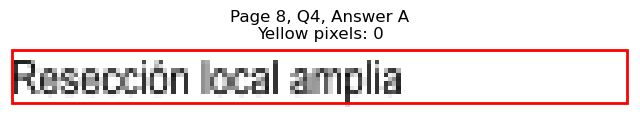

Page 8, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=145.6, y1=316.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 383
Page 8, Q4, B: Yellow percentage: 0.0%


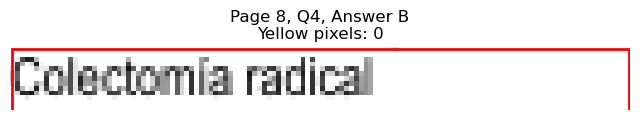

Page 8, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=427.4, y1=304.1
Page 8, Q4, C: Yellow pixels: 1567
Page 8, Q4, C: Total non-white pixels: 2114
Page 8, Q4, C: Yellow percentage: 74.1%


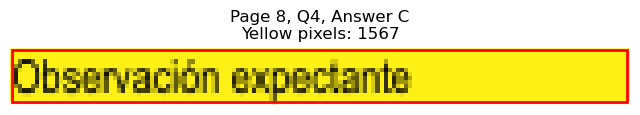

Page 8, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=375.8, y1=316.7
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 350
Page 8, Q4, D: Yellow percentage: 0.0%


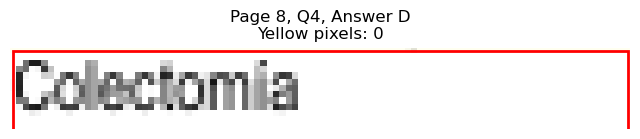


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=216.8, y1=367.2
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 744
Page 8, Q5, A: Yellow percentage: 0.0%


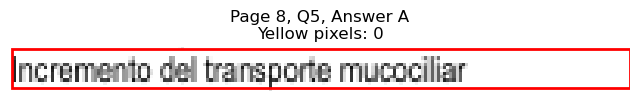

Page 8, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=221.8, y1=379.8
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 788
Page 8, Q5, B: Yellow percentage: 0.0%


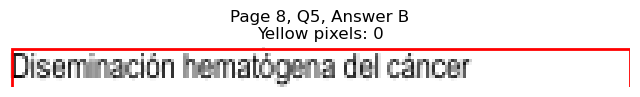

Page 8, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=475.1, y1=367.2
Page 8, Q5, C: Yellow pixels: 2066
Page 8, Q5, C: Total non-white pixels: 2786
Page 8, Q5, C: Yellow percentage: 74.2%


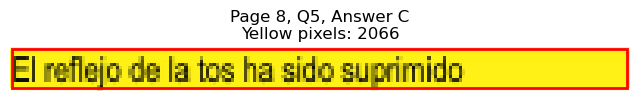

Page 8, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=393.3, y1=379.8
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 465
Page 8, Q5, D: Yellow percentage: 0.0%


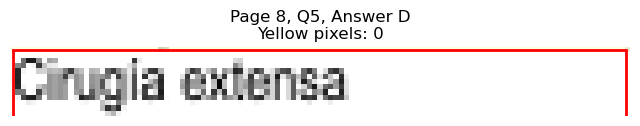


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=192.7, y1=430.3
Page 8, Q6, A: Yellow pixels: 1658
Page 8, Q6, A: Total non-white pixels: 2450
Page 8, Q6, A: Yellow percentage: 67.7%


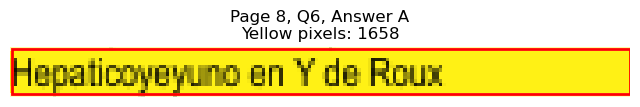

Page 8, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=160.1, y1=442.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 593
Page 8, Q6, B: Yellow percentage: 0.0%


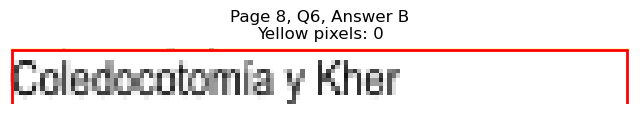

Page 8, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=382.7, y1=430.3
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 289
Page 8, Q6, C: Yellow percentage: 0.0%


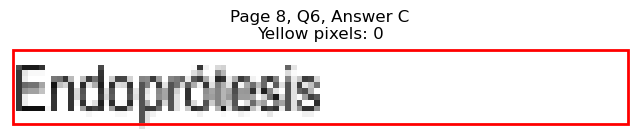

Page 8, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=448.9, y1=442.9
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 581
Page 8, Q6, D: Yellow percentage: 0.0%


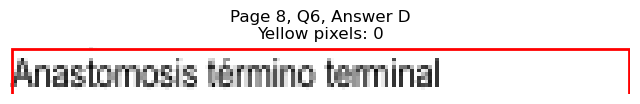


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=147.0, y1=480.7
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 378
Page 8, Q7, A: Yellow percentage: 0.0%


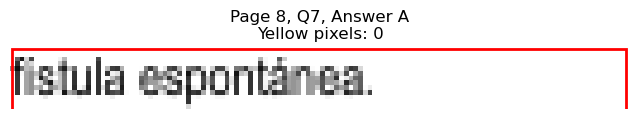

Page 8, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=146.1, y1=493.4
Page 8, Q7, B: Yellow pixels: 1245
Page 8, Q7, B: Total non-white pixels: 1806
Page 8, Q7, B: Yellow percentage: 68.9%


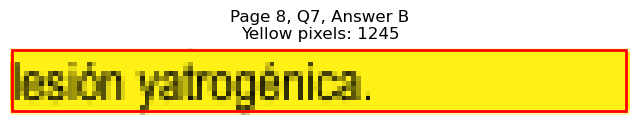

Page 8, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=429.9, y1=480.7
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 517
Page 8, Q7, C: Yellow percentage: 0.0%


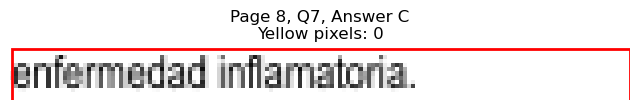

Page 8, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=399.8, y1=493.4
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 342
Page 8, Q7, D: Yellow percentage: 0.0%


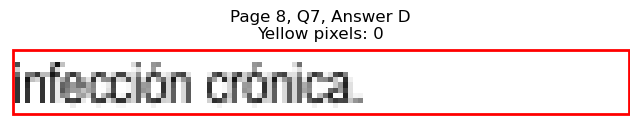


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=518.6, x1=102.9, y1=531.2
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 168
Page 8, Q8, A: Yellow percentage: 0.0%


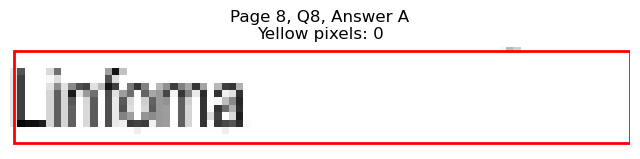

Page 8, Q8 - B: Detected box: x0=68.3, y0=531.2, x1=137.1, y1=543.8
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 339
Page 8, Q8, B: Yellow percentage: 0.0%


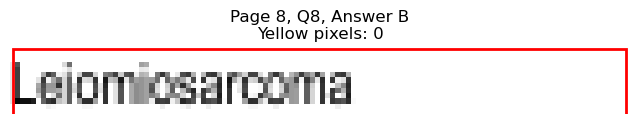

Page 8, Q8 - C: Detected box: x0=327.5, y0=518.6, x1=392.2, y1=531.2
Page 8, Q8, C: Yellow pixels: 116
Page 8, Q8, C: Total non-white pixels: 412
Page 8, Q8, C: Yellow percentage: 28.2%


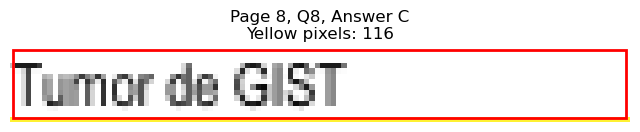

Page 8, Q8 - D: Detected box: x0=327.5, y0=531.2, x1=397.7, y1=543.8
Page 8, Q8, D: Yellow pixels: 1319
Page 8, Q8, D: Total non-white pixels: 1573
Page 8, Q8, D: Yellow percentage: 83.9%


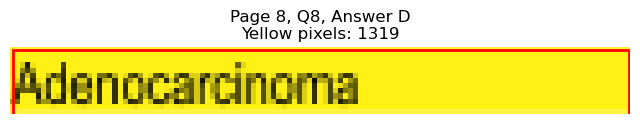


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=153.0, y1=619.6
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 439
Page 8, Q9, A: Yellow percentage: 0.0%


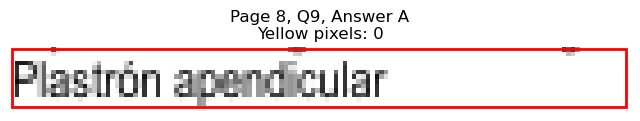

Page 8, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=159.0, y1=632.3
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 447
Page 8, Q9, B: Yellow percentage: 0.0%


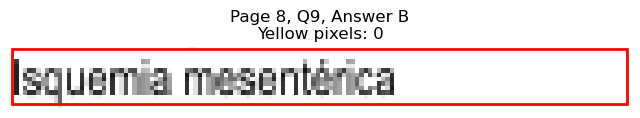

Page 8, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=396.3, y1=619.6
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 337
Page 8, Q9, C: Yellow percentage: 0.0%


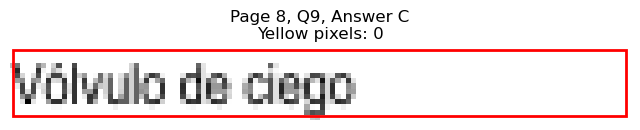

Page 8, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=366.2, y1=632.3
Page 8, Q9, D: Yellow pixels: 929
Page 8, Q9, D: Total non-white pixels: 1260
Page 8, Q9, D: Yellow percentage: 73.7%


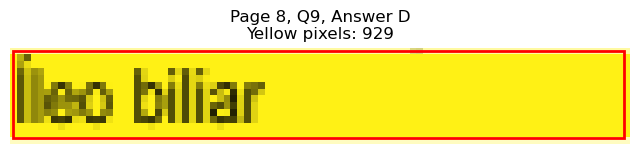


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=682.7, x1=187.7, y1=695.3
Page 8, Q10, A: Yellow pixels: 1590
Page 8, Q10, A: Total non-white pixels: 2380
Page 8, Q10, A: Yellow percentage: 66.8%


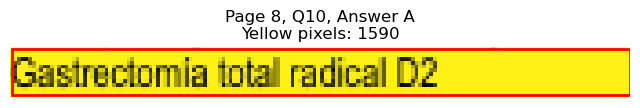

Page 8, Q10 - B: Detected box: x0=68.3, y0=695.4, x1=204.8, y1=708.0
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 877
Page 8, Q10, B: Yellow percentage: 0.0%


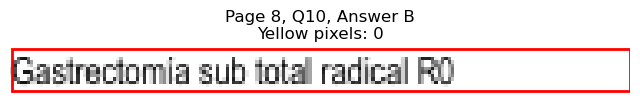

Page 8, Q10 - C: Detected box: x0=68.8, y0=708.0, x1=226.4, y1=720.6
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 770
Page 8, Q10, C: Yellow percentage: 0.0%


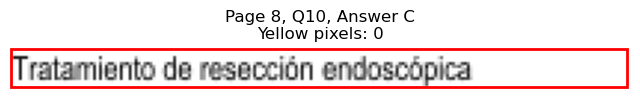

Page 8, Q10 - D: Detected box: x0=68.8, y0=720.6, x1=354.1, y1=733.2
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 1385
Page 8, Q10, D: Yellow percentage: 0.0%


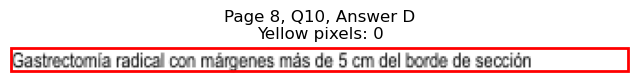


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=218.2, y1=114.7
Page 9, Q1, A: Yellow pixels: 2049
Page 9, Q1, A: Total non-white pixels: 2613
Page 9, Q1, A: Yellow percentage: 78.4%


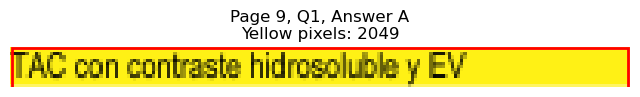

Page 9, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=142.5, y1=127.3
Page 9, Q1, B: Yellow pixels: 125
Page 9, Q1, B: Total non-white pixels: 474
Page 9, Q1, B: Yellow percentage: 26.4%


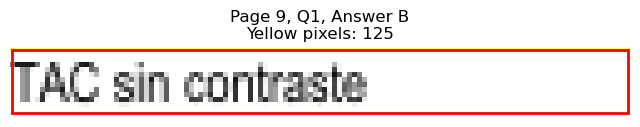

Page 9, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=413.3, y1=114.7
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 428
Page 9, Q1, C: Yellow percentage: 0.0%


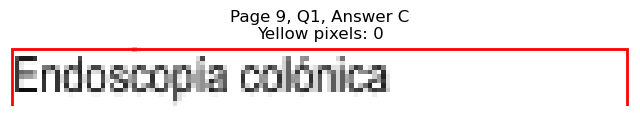

Page 9, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=449.5, y1=127.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 603
Page 9, Q1, D: Yellow percentage: 0.0%


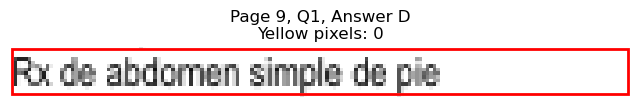


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=121.5, y1=165.2
Page 9, Q2, A: Yellow pixels: 104
Page 9, Q2, A: Total non-white pixels: 382
Page 9, Q2, A: Yellow percentage: 27.2%


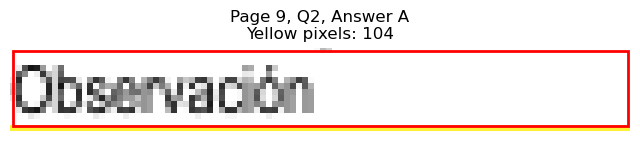

Page 9, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=121.5, y1=177.8
Page 9, Q2, B: Yellow pixels: 1150
Page 9, Q2, B: Total non-white pixels: 1352
Page 9, Q2, B: Yellow percentage: 85.1%


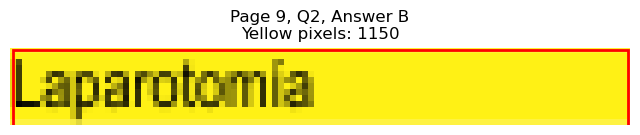

Page 9, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=409.3, y1=165.2
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 426
Page 9, Q2, C: Yellow percentage: 0.0%


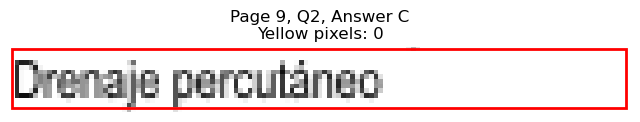

Page 9, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=379.7, y1=177.8
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 294
Page 9, Q2, D: Yellow percentage: 0.0%


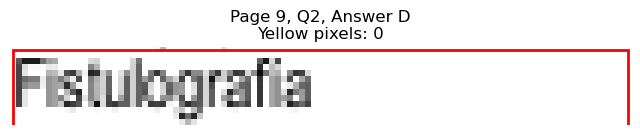


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=102.9, y1=240.9
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 183
Page 9, Q3, A: Yellow percentage: 0.0%


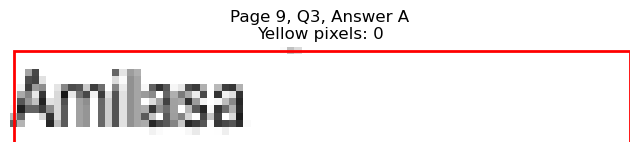

Page 9, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=134.5, y1=253.5
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 305
Page 9, Q3, B: Yellow percentage: 0.0%


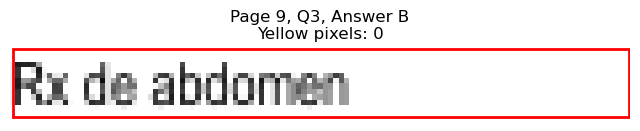

Page 9, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=412.9, y1=240.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 580
Page 9, Q3, C: Yellow percentage: 0.0%


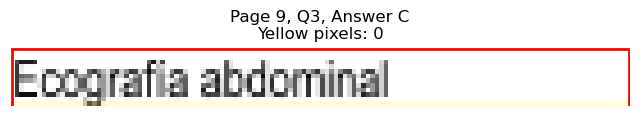

Page 9, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=356.7, y1=253.5
Page 9, Q3, D: Yellow pixels: 942
Page 9, Q3, D: Total non-white pixels: 1120
Page 9, Q3, D: Yellow percentage: 84.1%


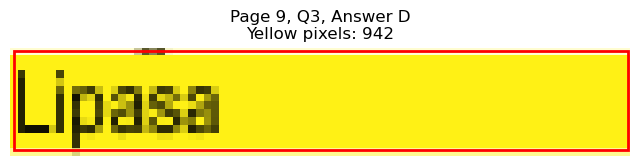


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=212.8, y1=316.7
Page 9, Q4, A: Yellow pixels: 1
Page 9, Q4, A: Total non-white pixels: 903
Page 9, Q4, A: Yellow percentage: 0.1%


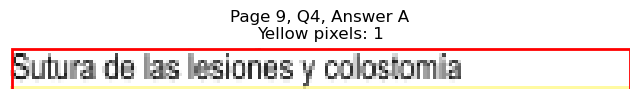

Page 9, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=274.0, y1=329.3
Page 9, Q4, B: Yellow pixels: 1806
Page 9, Q4, B: Total non-white pixels: 3036
Page 9, Q4, B: Yellow percentage: 59.5%


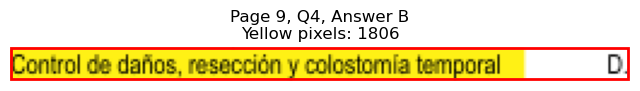

Page 9, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=467.6, y1=316.7
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 714
Page 9, Q4, C: Yellow percentage: 0.0%


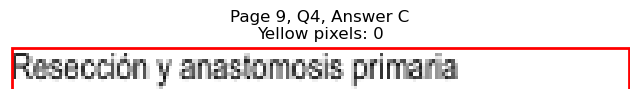

Page 9, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=423.4, y1=329.3
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 478
Page 9, Q4, D: Yellow percentage: 0.0%


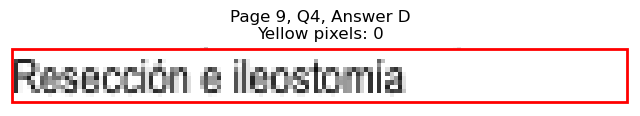


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=152.5, x1=121.5, y1=165.2
Page 9, Q5, A: Yellow pixels: 104
Page 9, Q5, A: Total non-white pixels: 382
Page 9, Q5, A: Yellow percentage: 27.2%


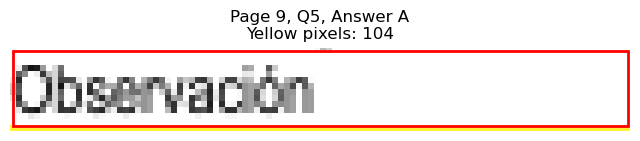

Page 9, Q5 - B: Detected box: x0=68.3, y0=165.1, x1=121.5, y1=177.8
Page 9, Q5, B: Yellow pixels: 1150
Page 9, Q5, B: Total non-white pixels: 1352
Page 9, Q5, B: Yellow percentage: 85.1%


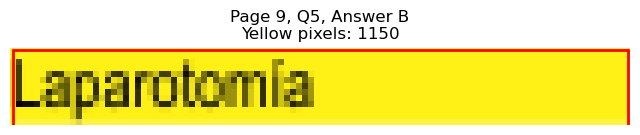

Page 9, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=353.1, y1=379.8
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 116
Page 9, Q5, C: Yellow percentage: 0.0%


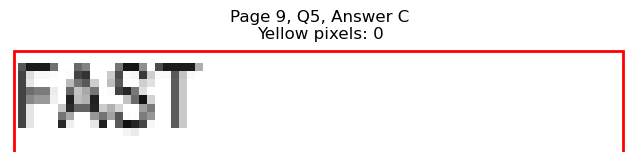

Page 9, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=347.6, y1=392.4
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 80
Page 9, Q5, D: Yellow percentage: 0.0%


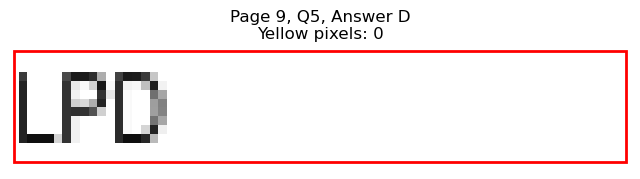


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=128.5, y1=430.3
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 280
Page 9, Q6, A: Yellow percentage: 0.0%


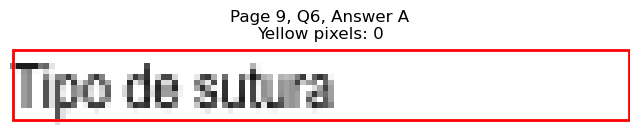

Page 9, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=109.5, y1=442.9
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 233
Page 9, Q6, B: Yellow percentage: 0.0%


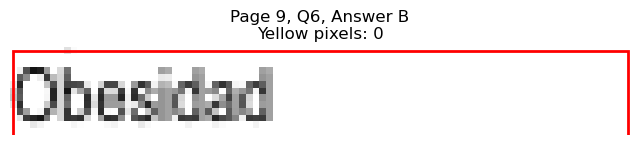

Page 9, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=374.2, y1=430.3
Page 9, Q6, C: Yellow pixels: 98
Page 9, Q6, C: Total non-white pixels: 355
Page 9, Q6, C: Yellow percentage: 27.6%


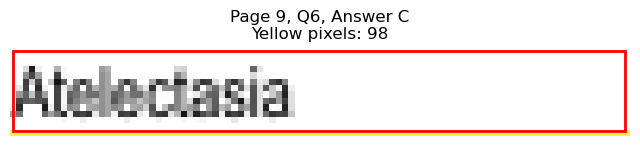

Page 9, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=439.4, y1=442.9
Page 9, Q6, D: Yellow pixels: 1670
Page 9, Q6, D: Total non-white pixels: 2119
Page 9, Q6, D: Yellow percentage: 78.8%


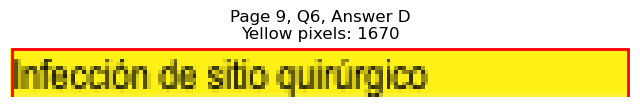


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=160.1, y1=480.7
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 446
Page 9, Q7, A: Yellow percentage: 0.0%


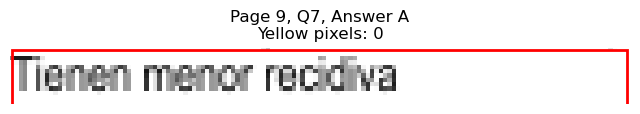

Page 9, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=143.1, y1=493.4
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 342
Page 9, Q7, B: Yellow percentage: 0.0%


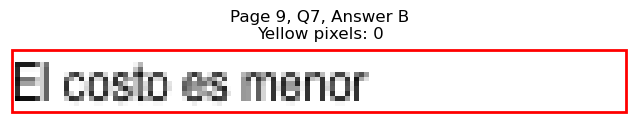

Page 9, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=505.7, y1=480.7
Page 9, Q7, C: Yellow pixels: 2100
Page 9, Q7, C: Total non-white pixels: 2782
Page 9, Q7, C: Yellow percentage: 75.5%


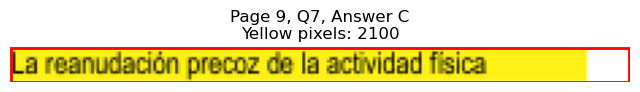

Page 9, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=463.4, y1=493.4
Page 9, Q7, D: Yellow pixels: 187
Page 9, Q7, D: Total non-white pixels: 840
Page 9, Q7, D: Yellow percentage: 22.3%


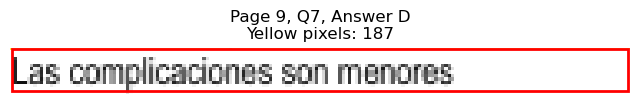


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=141.5, y1=543.8
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 376
Page 9, Q8, A: Yellow percentage: 0.0%


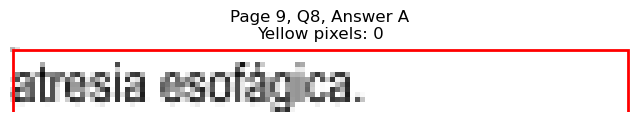

Page 9, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=144.5, y1=556.4
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 411
Page 9, Q8, B: Yellow percentage: 0.0%


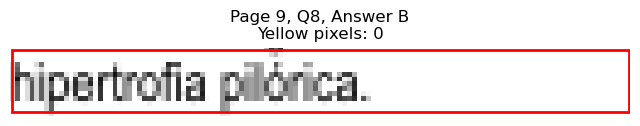

Page 9, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=428.3, y1=543.8
Page 9, Q8, C: Yellow pixels: 1598
Page 9, Q8, C: Total non-white pixels: 1976
Page 9, Q8, C: Yellow percentage: 80.9%


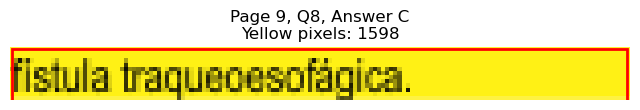

Page 9, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=423.3, y1=556.4
Page 9, Q8, D: Yellow pixels: 142
Page 9, Q8, D: Total non-white pixels: 652
Page 9, Q8, D: Yellow percentage: 21.8%


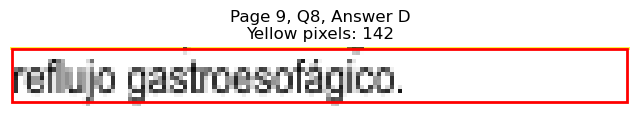


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=172.1, y1=632.3
Page 9, Q9, A: Yellow pixels: 155
Page 9, Q9, A: Total non-white pixels: 691
Page 9, Q9, A: Yellow percentage: 22.4%


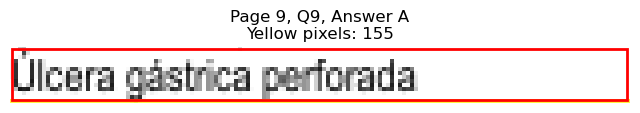

Page 9, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=145.6, y1=644.9
Page 9, Q9, B: Yellow pixels: 1329
Page 9, Q9, B: Total non-white pixels: 1664
Page 9, Q9, B: Yellow percentage: 79.9%


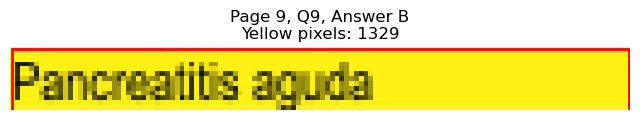

Page 9, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=400.7, y1=632.3
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 399
Page 9, Q9, C: Yellow percentage: 0.0%


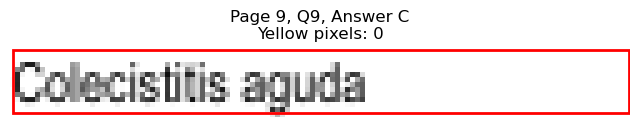

Page 9, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=392.7, y1=644.9
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 366
Page 9, Q9, D: Yellow percentage: 0.0%


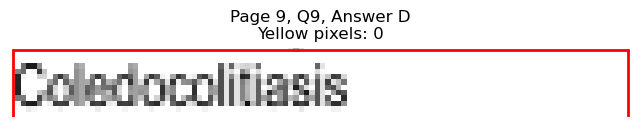


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=141.5, y1=682.7
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 372
Page 9, Q10, A: Yellow percentage: 0.0%


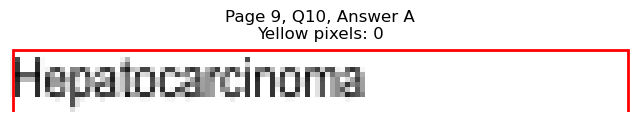

Page 9, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=135.5, y1=695.3
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 317
Page 9, Q10, B: Yellow percentage: 0.0%


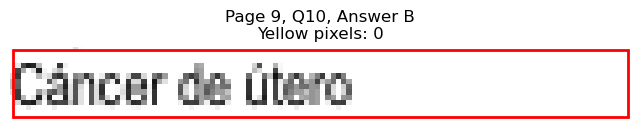

Page 9, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=434.9, y1=682.7
Page 9, Q10, C: Yellow pixels: 1634
Page 9, Q10, C: Total non-white pixels: 2054
Page 9, Q10, C: Yellow percentage: 79.6%


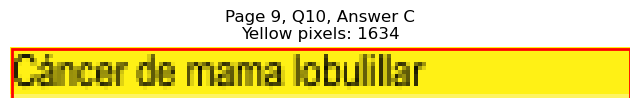

Page 9, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=411.3, y1=695.3
Page 9, Q10, D: Yellow pixels: 135
Page 9, Q10, D: Total non-white pixels: 553
Page 9, Q10, D: Yellow percentage: 24.4%


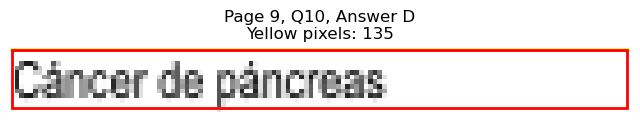


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=733.2, x1=143.2, y1=745.8
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 378
Page 9, Q11, A: Yellow percentage: 0.0%


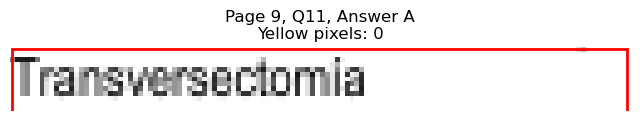

Page 9, Q11 - B: Detected box: x0=68.3, y0=745.8, x1=230.8, y1=758.4
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 833
Page 9, Q11, B: Yellow percentage: 0.0%


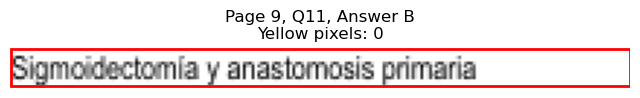

Page 9, Q11 - C: Detected box: x0=327.5, y0=733.2, x1=434.8, y1=745.8
Page 9, Q11, C: Yellow pixels: 1638
Page 9, Q11, C: Total non-white pixels: 2054
Page 9, Q11, C: Yellow percentage: 79.7%


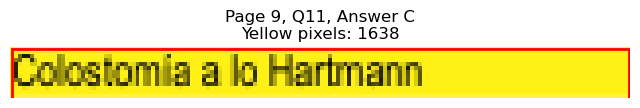

Page 9, Q11 - D: Detected box: x0=327.5, y0=745.8, x1=436.5, y1=758.4
Page 9, Q11, D: Yellow pixels: 160
Page 9, Q11, D: Total non-white pixels: 734
Page 9, Q11, D: Yellow percentage: 21.8%


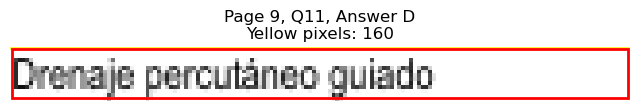


Page 9, Q11 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=164.7, y1=114.7
Page 10, Q1, A: Yellow pixels: 1526
Page 10, Q1, A: Total non-white pixels: 1911
Page 10, Q1, A: Yellow percentage: 79.9%


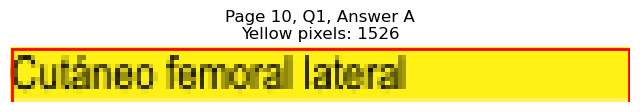

Page 10, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=118.9, y1=127.3
Page 10, Q1, B: Yellow pixels: 101
Page 10, Q1, B: Total non-white pixels: 314
Page 10, Q1, B: Yellow percentage: 32.2%


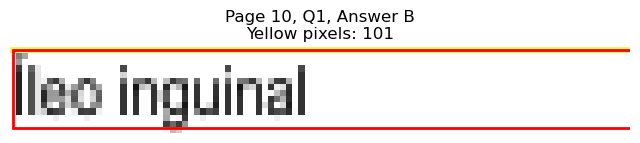

Page 10, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=369.7, y1=114.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 208
Page 10, Q1, C: Yellow percentage: 0.0%


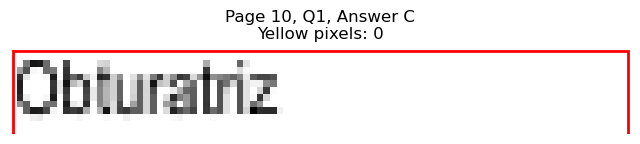

Page 10, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=441.4, y1=127.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 580
Page 10, Q1, D: Yellow percentage: 0.0%


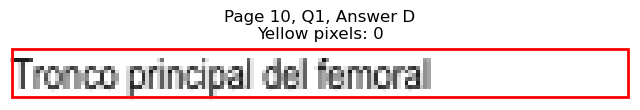


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=167.7, y1=177.8
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 510
Page 10, Q2, A: Yellow percentage: 0.0%


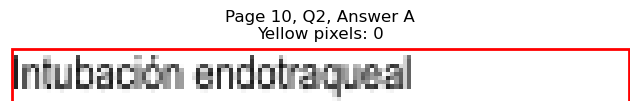

Page 10, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=226.4, y1=190.4
Page 10, Q2, B: Yellow pixels: 209
Page 10, Q2, B: Total non-white pixels: 988
Page 10, Q2, B: Yellow percentage: 21.2%


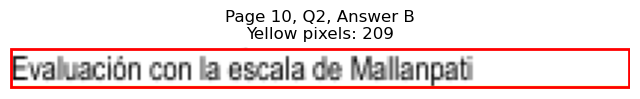

Page 10, Q2 - C: Detected box: x0=68.8, y0=190.3, x1=306.5, y1=203.0
Page 10, Q2, C: Yellow pixels: 2862
Page 10, Q2, C: Total non-white pixels: 3757
Page 10, Q2, C: Yellow percentage: 76.2%


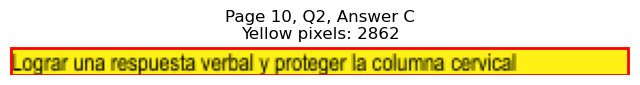

Page 10, Q2 - D: Detected box: x0=68.8, y0=202.9, x1=160.6, y1=215.6
Page 10, Q2, D: Yellow pixels: 134
Page 10, Q2, D: Total non-white pixels: 588
Page 10, Q2, D: Yellow percentage: 22.8%


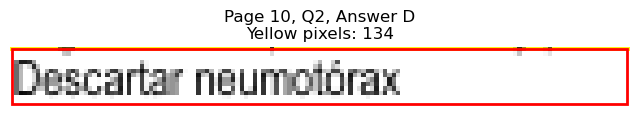


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=255.9, y1=266.1
Page 10, Q3, A: Yellow pixels: 213
Page 10, Q3, A: Total non-white pixels: 1171
Page 10, Q3, A: Yellow percentage: 18.2%


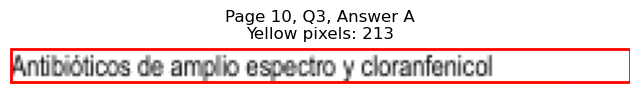

Page 10, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=254.9, y1=278.7
Page 10, Q3, B: Yellow pixels: 2008
Page 10, Q3, B: Total non-white pixels: 2782
Page 10, Q3, B: Yellow percentage: 72.2%


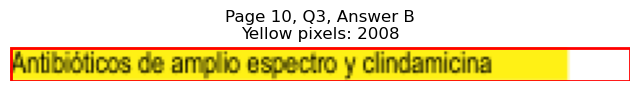

Page 10, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=444.4, y1=266.1
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 587
Page 10, Q3, C: Yellow percentage: 0.0%


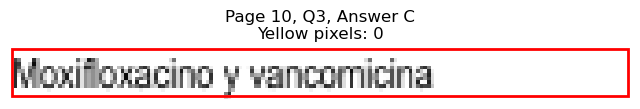

Page 10, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=441.4, y1=278.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 596
Page 10, Q3, D: Yellow percentage: 0.0%


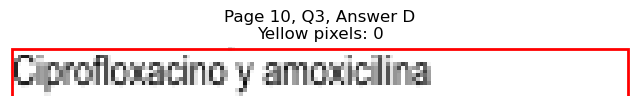


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=148.6, y1=316.7
Page 10, Q4, A: Yellow pixels: 1372
Page 10, Q4, A: Total non-white pixels: 1703
Page 10, Q4, A: Yellow percentage: 80.6%


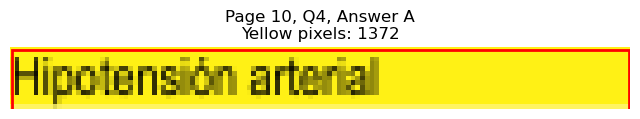

Page 10, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=148.6, y1=329.3
Page 10, Q4, B: Yellow pixels: 131
Page 10, Q4, B: Total non-white pixels: 509
Page 10, Q4, B: Yellow percentage: 25.7%


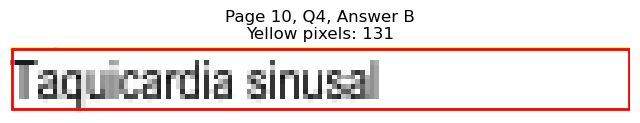

Page 10, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=399.4, y1=316.7
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 369
Page 10, Q4, C: Yellow percentage: 0.0%


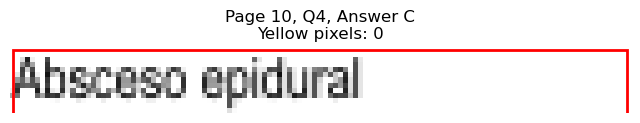

Page 10, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=410.8, y1=329.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 449
Page 10, Q4, D: Yellow percentage: 0.0%


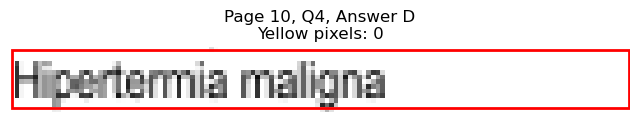


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=120.0, y1=379.8
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 365
Page 10, Q5, A: Yellow percentage: 0.0%


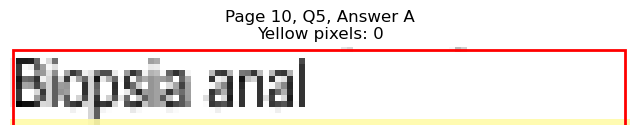

Page 10, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=101.4, y1=392.4
Page 10, Q5, B: Yellow pixels: 883
Page 10, Q5, B: Total non-white pixels: 1176
Page 10, Q5, B: Yellow percentage: 75.1%


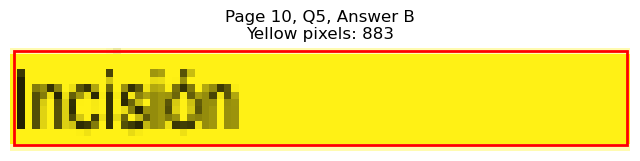

Page 10, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=382.7, y1=379.8
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 282
Page 10, Q5, C: Yellow percentage: 0.0%


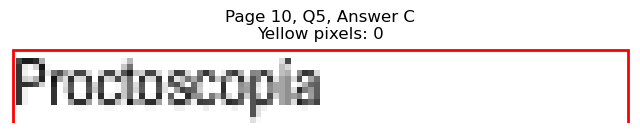

Page 10, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=413.3, y1=392.4
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 448
Page 10, Q5, D: Yellow percentage: 0.0%


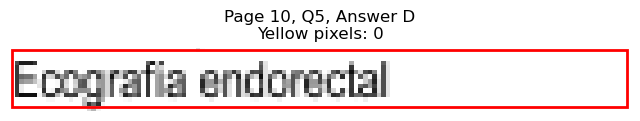


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=97.9, y1=455.5
Page 10, Q6, A: Yellow pixels: 80
Page 10, Q6, A: Total non-white pixels: 245
Page 10, Q6, A: Yellow percentage: 32.7%


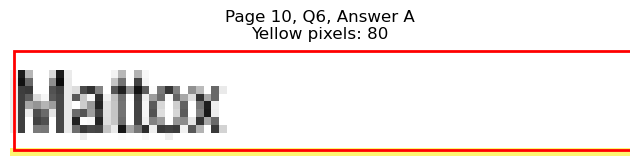

Page 10, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=98.9, y1=468.1
Page 10, Q6, B: Yellow pixels: 932
Page 10, Q6, B: Total non-white pixels: 1134
Page 10, Q6, B: Yellow percentage: 82.2%


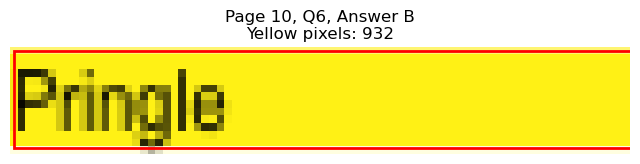

Page 10, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=358.6, y1=455.5
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 166
Page 10, Q6, C: Yellow percentage: 0.0%


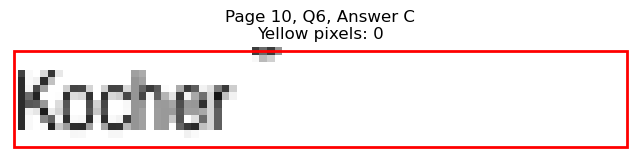

Page 10, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=355.1, y1=468.1
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 129
Page 10, Q6, D: Yellow percentage: 0.0%


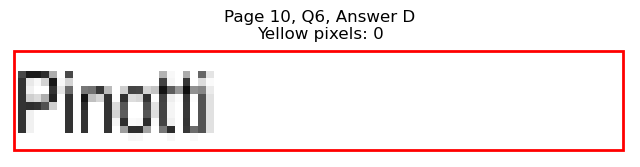


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=250.4, y1=506.0
Page 10, Q7, A: Yellow pixels: 2060
Page 10, Q7, A: Total non-white pixels: 2789
Page 10, Q7, A: Yellow percentage: 73.9%


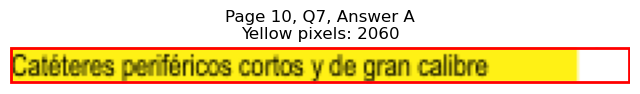

Page 10, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=217.4, y1=518.6
Page 10, Q7, B: Yellow pixels: 192
Page 10, Q7, B: Total non-white pixels: 915
Page 10, Q7, B: Yellow percentage: 21.0%


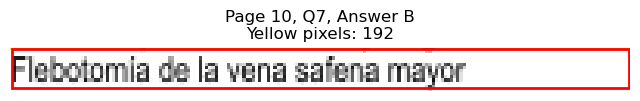

Page 10, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=440.5, y1=506.0
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 551
Page 10, Q7, C: Yellow percentage: 0.0%


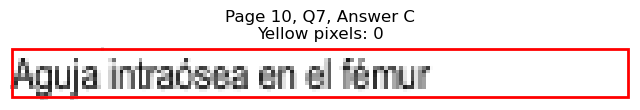

Page 10, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=466.4, y1=518.6
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 714
Page 10, Q7, D: Yellow percentage: 0.0%


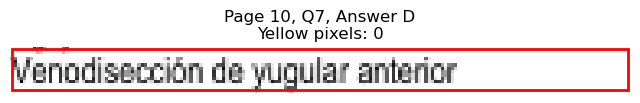


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 70 años operado por trombosis mesenté...
1   ¿Cuál es la complicación más común en la hemor...
2   Mujer de 60 años, sometida a gastrectomía subt...
3   ¿Cuál es la indicación quirúrgica de urgencia ...
4   Mujer de 32 años, durante una apendicectomía s...
..                                                ...
95  Varón de 60 años, obeso, presenta síndrome de ...
96  ¿Cuál es la complicación que se puede presenta...
97  Varón de 40 años, desde hace tres días present...
98  Varón de 60 años que sufre accidente de tránsi...
99  ¿Cuál acceso intravenoso se recomienda ante el...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                              Evitar la dermatitis   
1                         Hemorragia postoperatoria   
2                                    Dumping tardío   
3                                  Megacolon tóxico   
4                            Hemicolectomía derecha   
..                                              ...   
95  Antibióticos de amplio espectro y cloranfenicol   
96                             Hipotensión arterial   
97                                     Biopsia anal   
98                                           Mattox   
99   Catéteres periféricos cortos y de gran calibre   

                                          option_B  \
0                             Controlar la diarrea   
1                               Retención urinaria   
2                               Vaciamiento rápido   
3                           Fístula enteroentérica   
4    Apendicectomía con resección del mesoapéndice   
..                                             ...   
95  Antibióticos de amplio espectro y clindamicina   
96                             Taquicardia sinusal   
97                                        Incisión   
98                                         Pringle   
99              Flebotomía de la vena safena mayor   

                          option_C  \
0   Evitar déficit de Vitamina B12   
1                   Estenosis anal   
2        Intolerancia a la lactosa   
3                  Fisura perineal   
4            Apendicectomía simple   
..                             ...   
95     Moxifloxacino y vancomicina   
96                Absceso epidural   
97                    Proctoscopía   
98                          Kocher   
99     Aguja intraósea en el fémur   

                                             option_D  
0                         Control de hipergastrinemia  
1                                 Incontinencia fecal  
2            Intolerancia a suplementos nutricionales  
3                                   Neoplasia maligna  
4   Hemicolectomía derecha y linfoadenectomía regi...  
..                                                ...  
95                       Ciprofloxacino y amoxicilina  
96                                Hipertermia maligna  
97                               Ecografía endorectal  
98                                            Pinotti  
99                  Venodisección de yugular anterior  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 70 años operado por trombosis mesenté...   
1   ¿Cuál es la complicación más común en la hemor...   
2   Mujer de 60 años, sometida a gastrectomía subt...   
3   ¿Cuál es la indicación quirúrgica de urgencia ...   
4   Mujer de 32 años, durante una apendicectomía s...   
..                                                ...   
95  Varón de 60 años, obeso, presenta síndrome de ...   
96  ¿Cuál es la complicación que se puede presenta...   
97  Varón de 40 años, desde hace tres días present...   
98  Varón de 60 años que sufre accidente de tránsi...   
99  ¿Cuál acceso intravenoso se recomienda ante el...   

                                           option_A  \
0                              Evitar la dermatitis   
1                         Hemorragia postoperatoria   
2                                    Dumping tardío   
3                                  Megacolon tóxico   
4                            Hemicolectomía derecha   
..                                              ...   
95  Antibióticos de amplio espectro y cloranfenicol   
96                             Hipotensión arterial   
97                                     Biopsia anal   
98                                           Mattox   
99   Catéteres periféricos cortos y de gran calibre   

                                          option_B  \
0                             Controlar la diarrea   
1                               Retención urinaria   
2                               Vaciamiento rápido   
3                           Fístula enteroentérica   
4    Apendicectomía con resección del mesoapéndice   
..                                             ...   
95  Antibióticos de amplio espectro y clindamicina   
96                             Taquicardia sinusal   
97                                        Incisión   
98                                         Pringle   
99              Flebotomía de la vena safena mayor   

                          option_C  \
0   Evitar déficit de Vitamina B12   
1                   Estenosis anal   
2        Intolerancia a la lactosa   
3                  Fisura perineal   
4            Apendicectomía simple   
..                             ...   
95     Moxifloxacino y vancomicina   
96                Absceso epidural   
97                    Proctoscopía   
98                          Kocher   
99     Aguja intraósea en el fémur   

                                             option_D correct_answer  
0                         Control de hipergastrinemia              B  
1                                 Incontinencia fecal              B  
2            Intolerancia a suplementos nutricionales              A  
3                                   Neoplasia maligna              A  
4   Hemicolectomía derecha y linfoadenectomía regi...              D  
..                                                ...            ...  
95                       Ciprofloxacino y amoxicilina              B  
96                                Hipertermia maligna              A  
97                               Ecografía endorectal              B  
98                                            Pinotti              B  
99                  Venodisección de yugular anterior              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/CIRUGÍA.csv
